In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
COLORS = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS) 

In [2]:
class ImageClassifier(nn.Module):
    """
    A simple convolutional neural network for image classification.
    """

    def __init__(self, image_shape, num_classes, dropout=None, batch_norm=False):
        """
        Initializes the image classifier.

        Parameters
        ----------
        image_shape : tuple
            The shape of the input image.
        num_classes : int
            The number of classes to predict.
        dropout : float
            The dropout rate to use.
        batch_norm : bool
            Whether or not to use batch normalization.
        """

        super(ImageClassifier, self).__init__()
        self.image_width, self.image_height, self.image_channels = image_shape
        self.num_classes = num_classes

        self.convolution_layer1 = nn.Conv2d(in_channels=self.image_channels, out_channels=4, kernel_size=5, stride=1)
        self.maxpool1 = nn.Sequential(nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.convolution_layer2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1)
        self.maxpool2 = nn.Sequential(nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten_dim = self.getFlattenDim()
        layers = [nn.Linear(in_features=self.flatten_dim, out_features=49)]
        
        if batch_norm is not None:
            layers.append(nn.BatchNorm1d(num_features=49))
        layers.append(nn.ReLU(inplace=True))
        if dropout is not None:
            layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(in_features=49, out_features=self.num_classes))

        self.linear_layer = nn.Sequential(*layers)
    
    def forward(self, input_image):
        """
        Performs a forward pass through the network.

        Parameters
        ----------
        input_image : torch.Tensor
            The input image to the network.
        
        Returns
        -------
            The output of the network.
        """

        features = self.convolution_layer1(input_image) # Convolutional layers
        features = self.maxpool1(features)              # Max pooling
        features = self.convolution_layer2(features)    # Convolutional layers
        features = self.maxpool2(features)              # Max pooling
        features = features.view(-1, self.flatten_dim)  # Unravel the output of the convolutional layers
        features = self.linear_layer(features)          # Linear layers
        features = F.softmax(features, dim=1)           # Softmax activation function

        return features

    def getFlattenDim(self):
        """
        Returns the dimension of the flattened output of the convolutional layers.

        Returns
        -------
            The dimension of the flattened output.
        """

        x = torch.zeros(1, self.image_channels, self.image_height, self.image_width)
        x = self.convolution_layer1(x)
        x = self.maxpool1(x)
        x = self.convolution_layer2(x)
        x = self.maxpool2(x)
        return x.shape[1] * x.shape[2] * x.shape[3]

### MNIST Dataloader

In [3]:
# MNIST dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
traindataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testdataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
# Choose 100 random images per class for training
train_images = []
train_labels = []
for i in range(10):
    indices = np.random.choice(np.where(traindataset.targets == i)[0], 100)
    train_images.append(traindataset.data[indices])
    train_labels.append(traindataset.targets[indices])

train_images = (torch.cat(train_images, dim=0)/255).float() # Normalize the images
train_images = train_images.unsqueeze(1)                    # Add a channel dimension
train_labels = torch.cat(train_labels, dim=0)
trainset = torch.utils.data.TensorDataset(train_images, train_labels)

In [5]:
# Choose 10 random images per class for testing
test_images = []
test_labels = []
for i in range(10):
    indices = np.random.choice(np.where(testdataset.targets == i)[0], 10)
    test_images.append(testdataset.data[indices])
    test_labels.append(testdataset.targets[indices])

test_images = (torch.cat(test_images, dim=0)/255).float() # Normalize the images
test_images = test_images.unsqueeze(1)                    # Add a channel dimension
targets = torch.cat(test_labels, dim=0)
testset = torch.utils.data.TensorDataset(test_images, targets)

In [6]:
def trainLoop(model, trainloader, optimizer):
    """
    Trains the model.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    trainloader : torch.utils.data.DataLoader
        The training data.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    
    Returns
    -------
    model : nn.Module
        The trained model.
    train_loss : float
        The training loss.
    train_accuracy : float
        The training accuracy.
    """

    model.train()
    train_loss = 0.0
    train_accuracy = 0
    train_examples = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(images)
        train_examples += len(images)

        prediction = torch.argmax(output, dim=1)
        train_accuracy += torch.sum(prediction == labels).item()
    
    train_loss /= train_examples
    train_accuracy /= train_examples

    return model, train_loss, train_accuracy

In [7]:
def valLoop(model, testloader):
    """
    Validates the model.

    Parameters
    ----------
    model : nn.Module
        The model to validate.
    testloader : torch.utils.data.DataLoader
        The validation data.

    Returns
    -------
    val_loss : float
        The validation loss.
    val_accuracy : float
        The validation accuracy.
    """

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    val_examples = 0

    with torch.no_grad():
        for images, labels in testloader:
            output = model(images)
            loss = F.cross_entropy(output, labels)

            val_loss += loss.item() * len(images)
            val_examples += len(images)

            prediction = torch.argmax(output, dim=1)
            val_accuracy += torch.sum(prediction == labels).item()
    
    val_loss /= val_examples
    val_accuracy /= val_examples

    return val_loss, val_accuracy

In [8]:
epochs = 15
batch_sizes = [8, 16, 32, 64, 128]

### Vanilla SGD

In [9]:
cache = {}
for idx, batch in enumerate(batch_sizes):
    cache_per_batch = {}

    model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    activation_map1 = []
    activation_map2 = []

    for epoch in range(epochs):
        model.train()
        model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)
        val_loss, val_accuracy = valLoop(model, testloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        model.eval()
        with torch.no_grad():
            image, label = testset[0]
            image = image.unsqueeze(0) # Add a batch dimension
            output = model.convolution_layer1(image)
            layer1_output = output.detach().numpy().squeeze(0)

            output = model.maxpool1(output)
            output = model.convolution_layer2(output)
            layer2_output = output.detach().numpy().squeeze(0)

        layer1_output = (layer1_output * 255).astype(np.uint8)
        layer2_output = (layer2_output * 255).astype(np.uint8)

        activation_map1.append(layer1_output)
        activation_map2.append(layer2_output)
    
    cache_per_batch["train_losses"] = train_losses
    cache_per_batch["train_accuracies"] = train_accuracies
    cache_per_batch["val_losses"] = val_losses
    cache_per_batch["val_accuracies"] = val_accuracies
    cache_per_batch["activation_map1"] = activation_map1
    cache_per_batch["activation_map2"] = activation_map2

    cache[f"BatchSize_{batch}"] = cache_per_batch.copy()

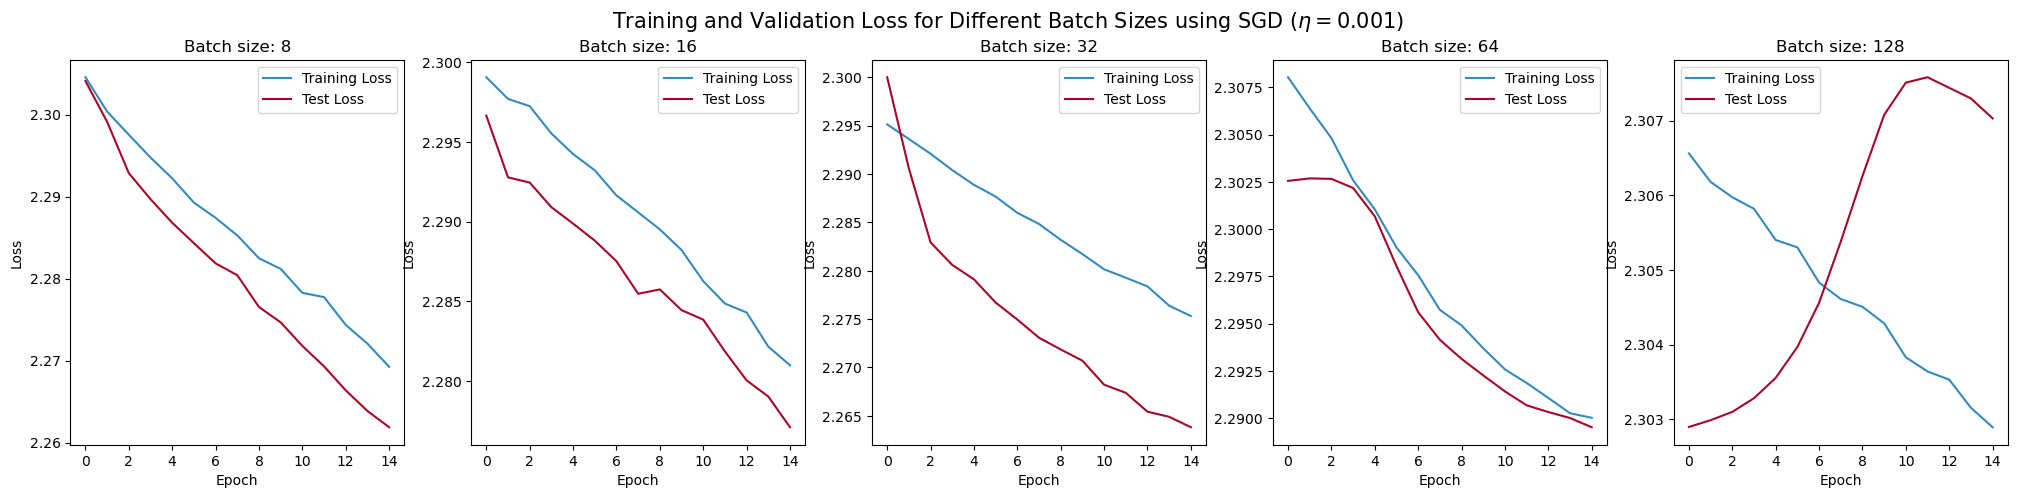

In [10]:
# Plotting the training and validation loss
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_losses = cache[key]["train_losses"]
    val_losses = cache[key]["val_losses"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_losses, label=f"Training Loss")
    plt.plot(val_losses, label=f"Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Batch size: {key.split('_')[1]}")
    plt.legend()
plt.suptitle(r"Training and Validation Loss for Different Batch Sizes using SGD ($\eta = 0.001$)", fontsize=15)
plt.show()

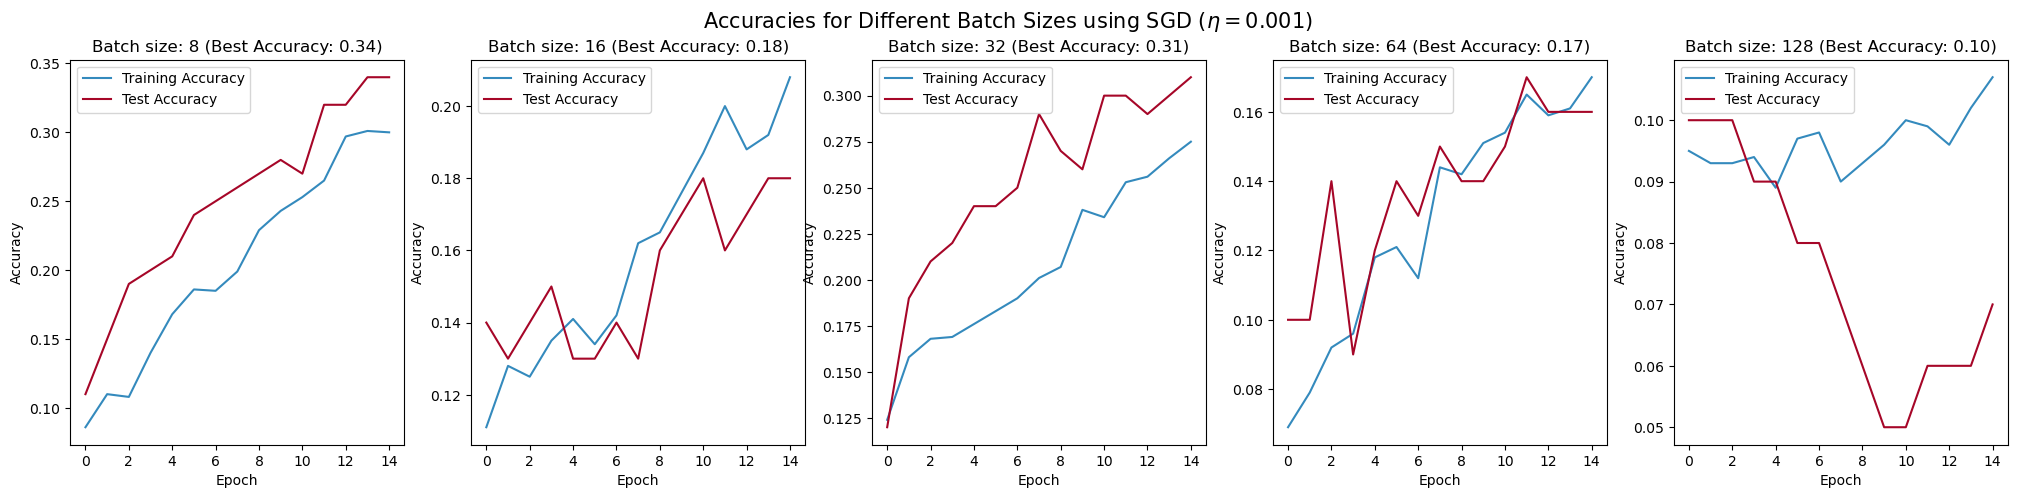

In [11]:
# Plotting the training and validation accuracy
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_accuracies = cache[key]["train_accuracies"]
    val_accuracies = cache[key]["val_accuracies"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_accuracies, label=f"Training Accuracy")
    plt.plot(val_accuracies, label=f"Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Batch size: {key.split('_')[1]} (Best Accuracy: {max(val_accuracies):.2f})")
    plt.legend()
plt.suptitle(r"Accuracies for Different Batch Sizes using SGD ($\eta = 0.001$)", fontsize=15)
plt.show()

### Plotting Activation Maps for Vanilla SGD

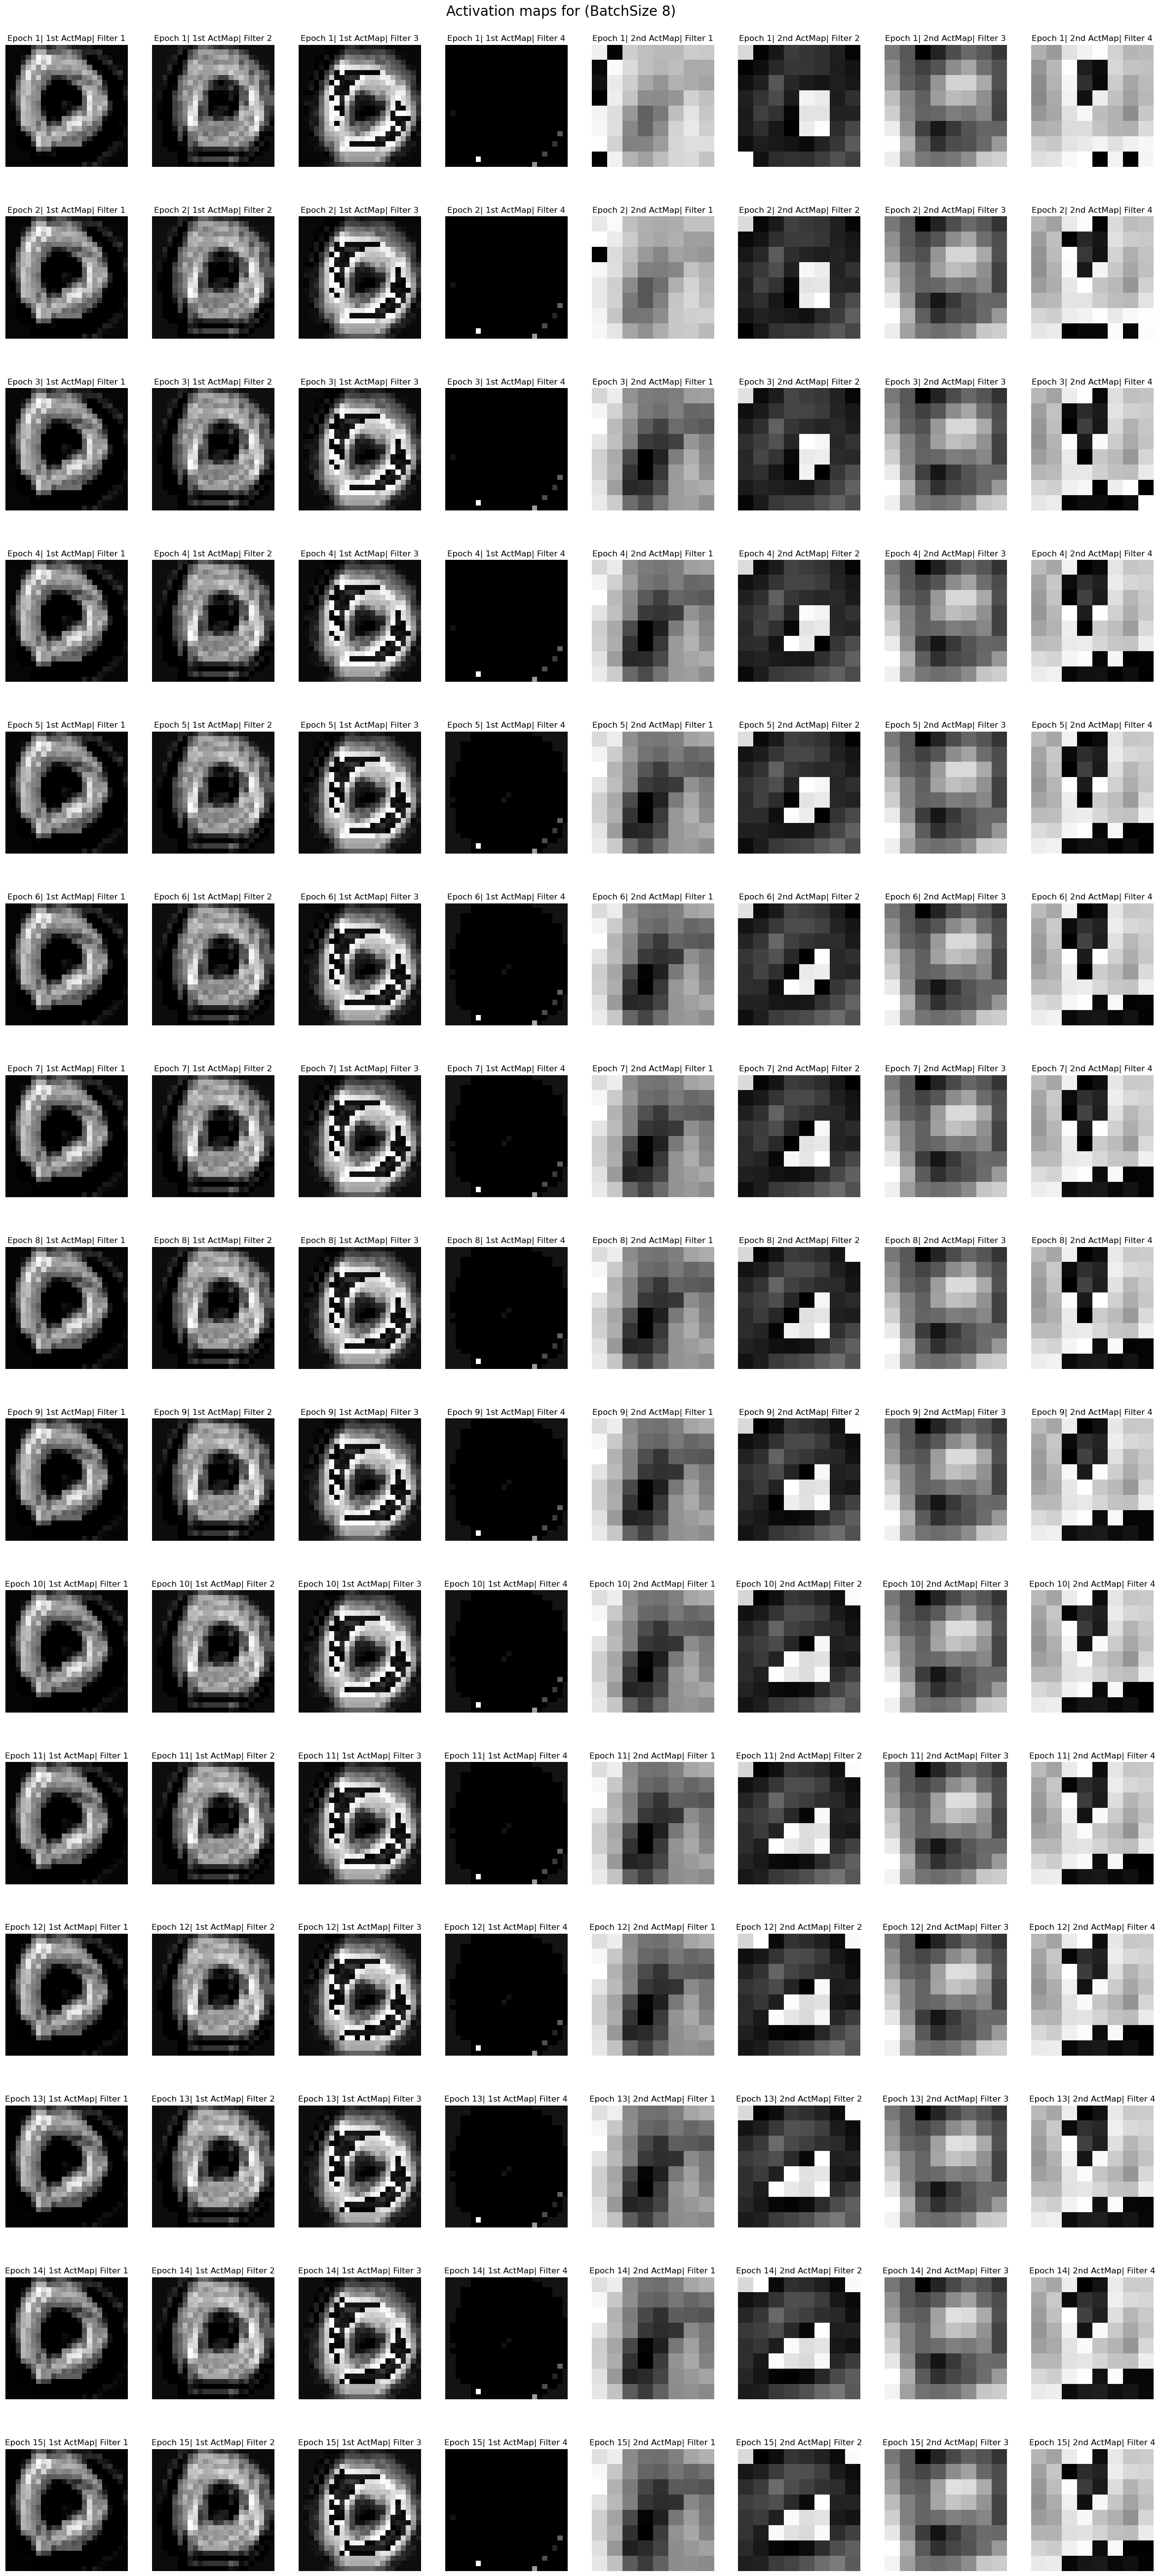

In [12]:
# Plotting the activation maps for BatchSize_8
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_8"]["activation_map1"]
activation_map2 = cache["BatchSize_8"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 8)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

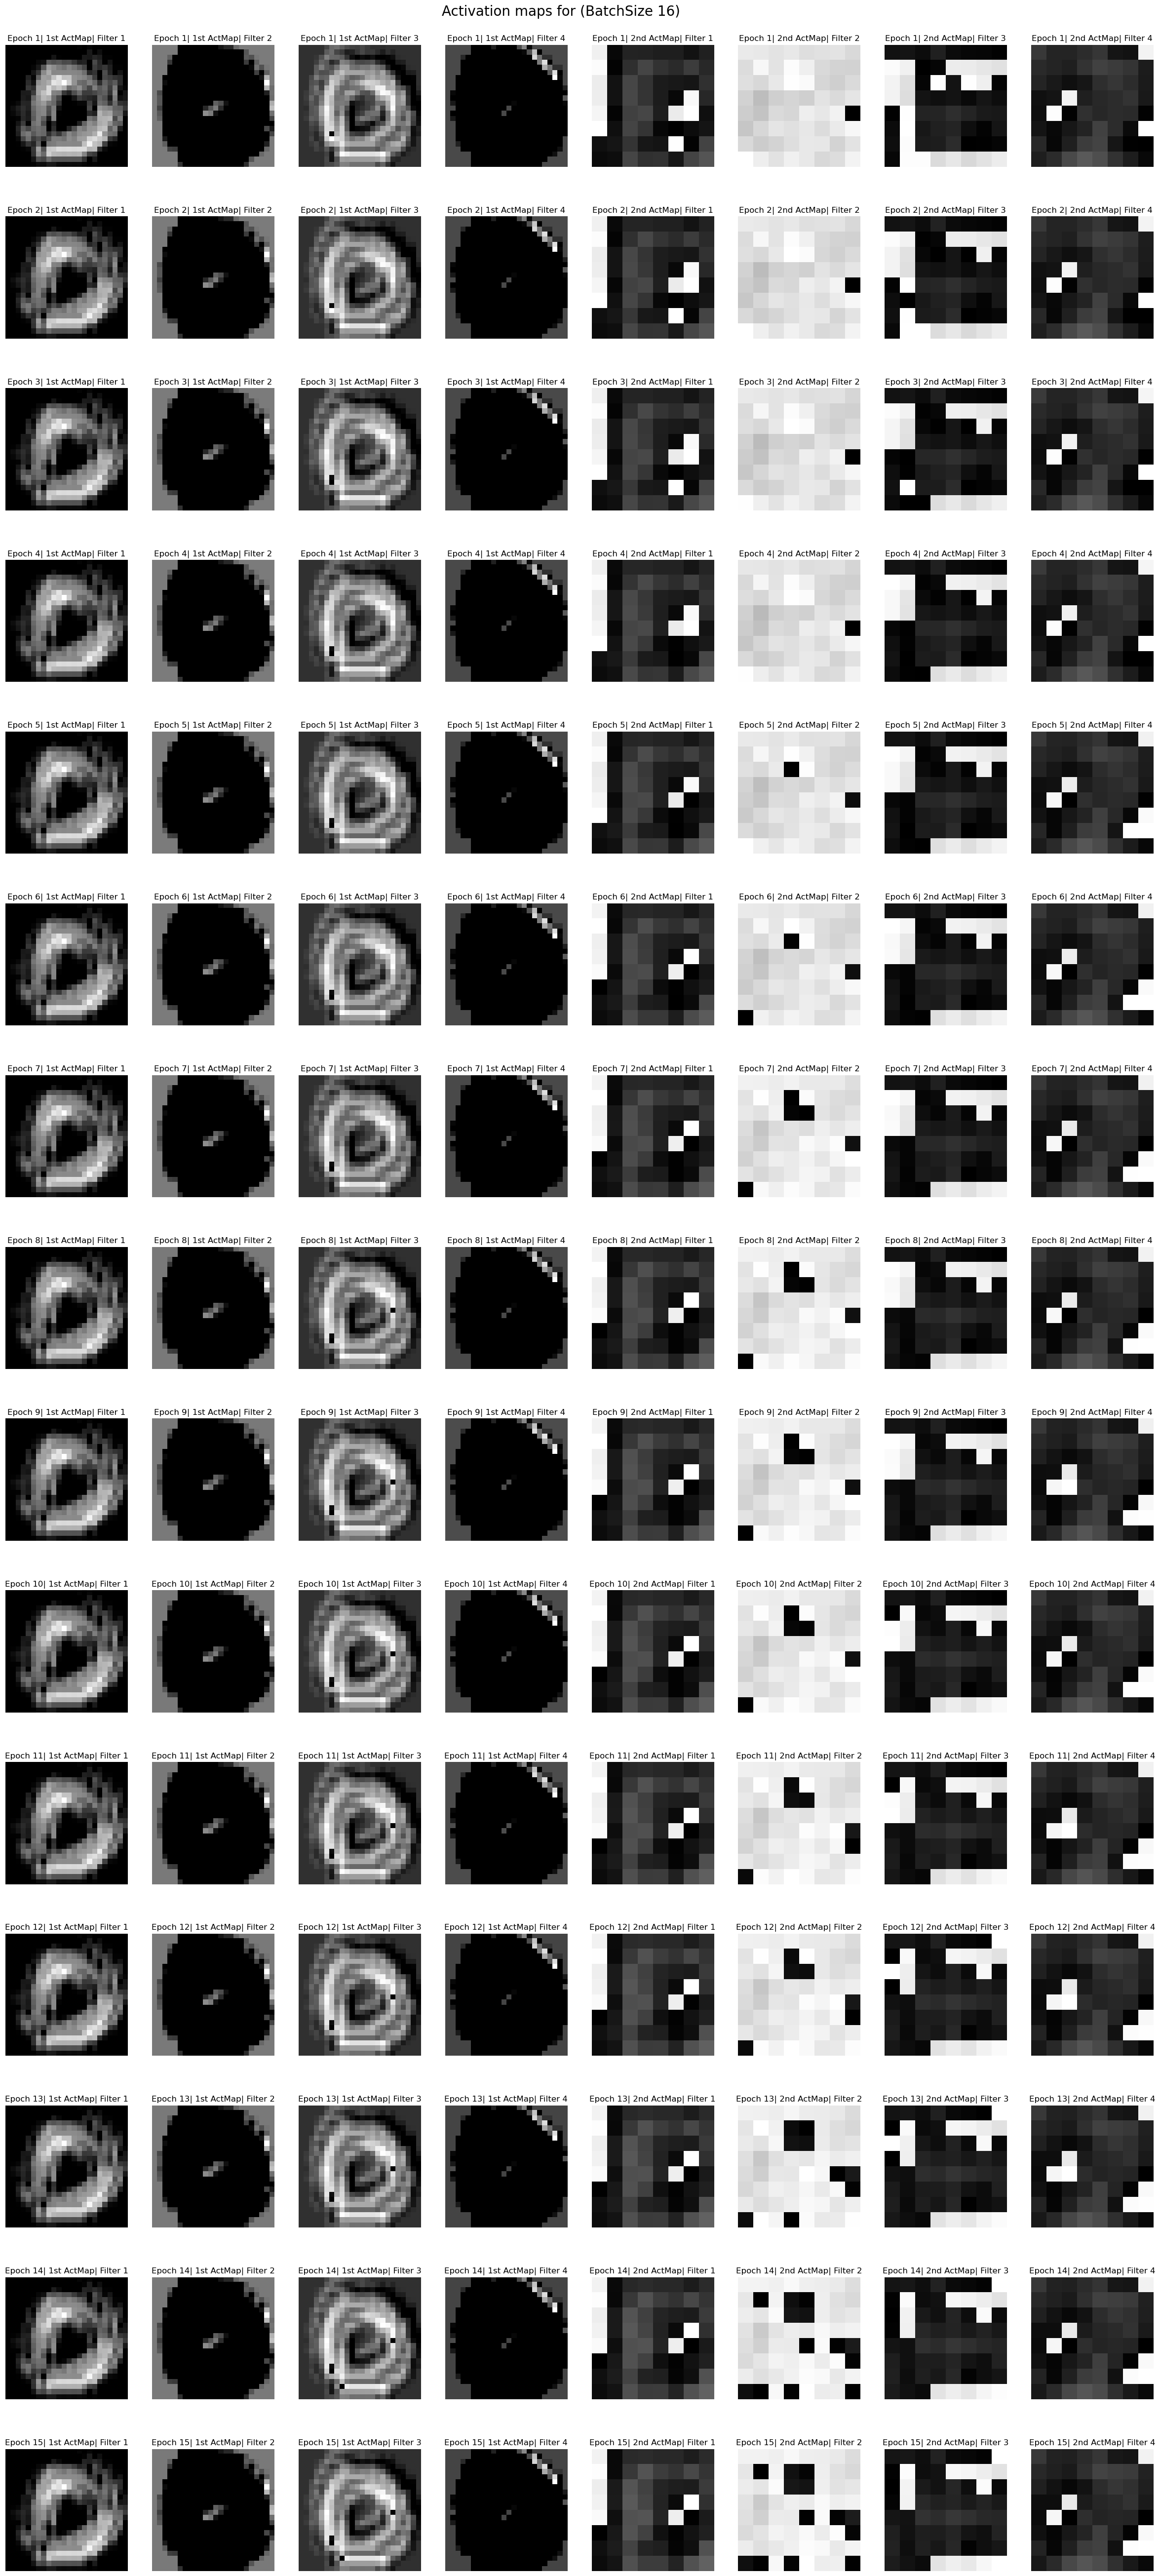

In [13]:
# Plotting the activation maps for BatchSize_16
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_16"]["activation_map1"]
activation_map2 = cache["BatchSize_16"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 16)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

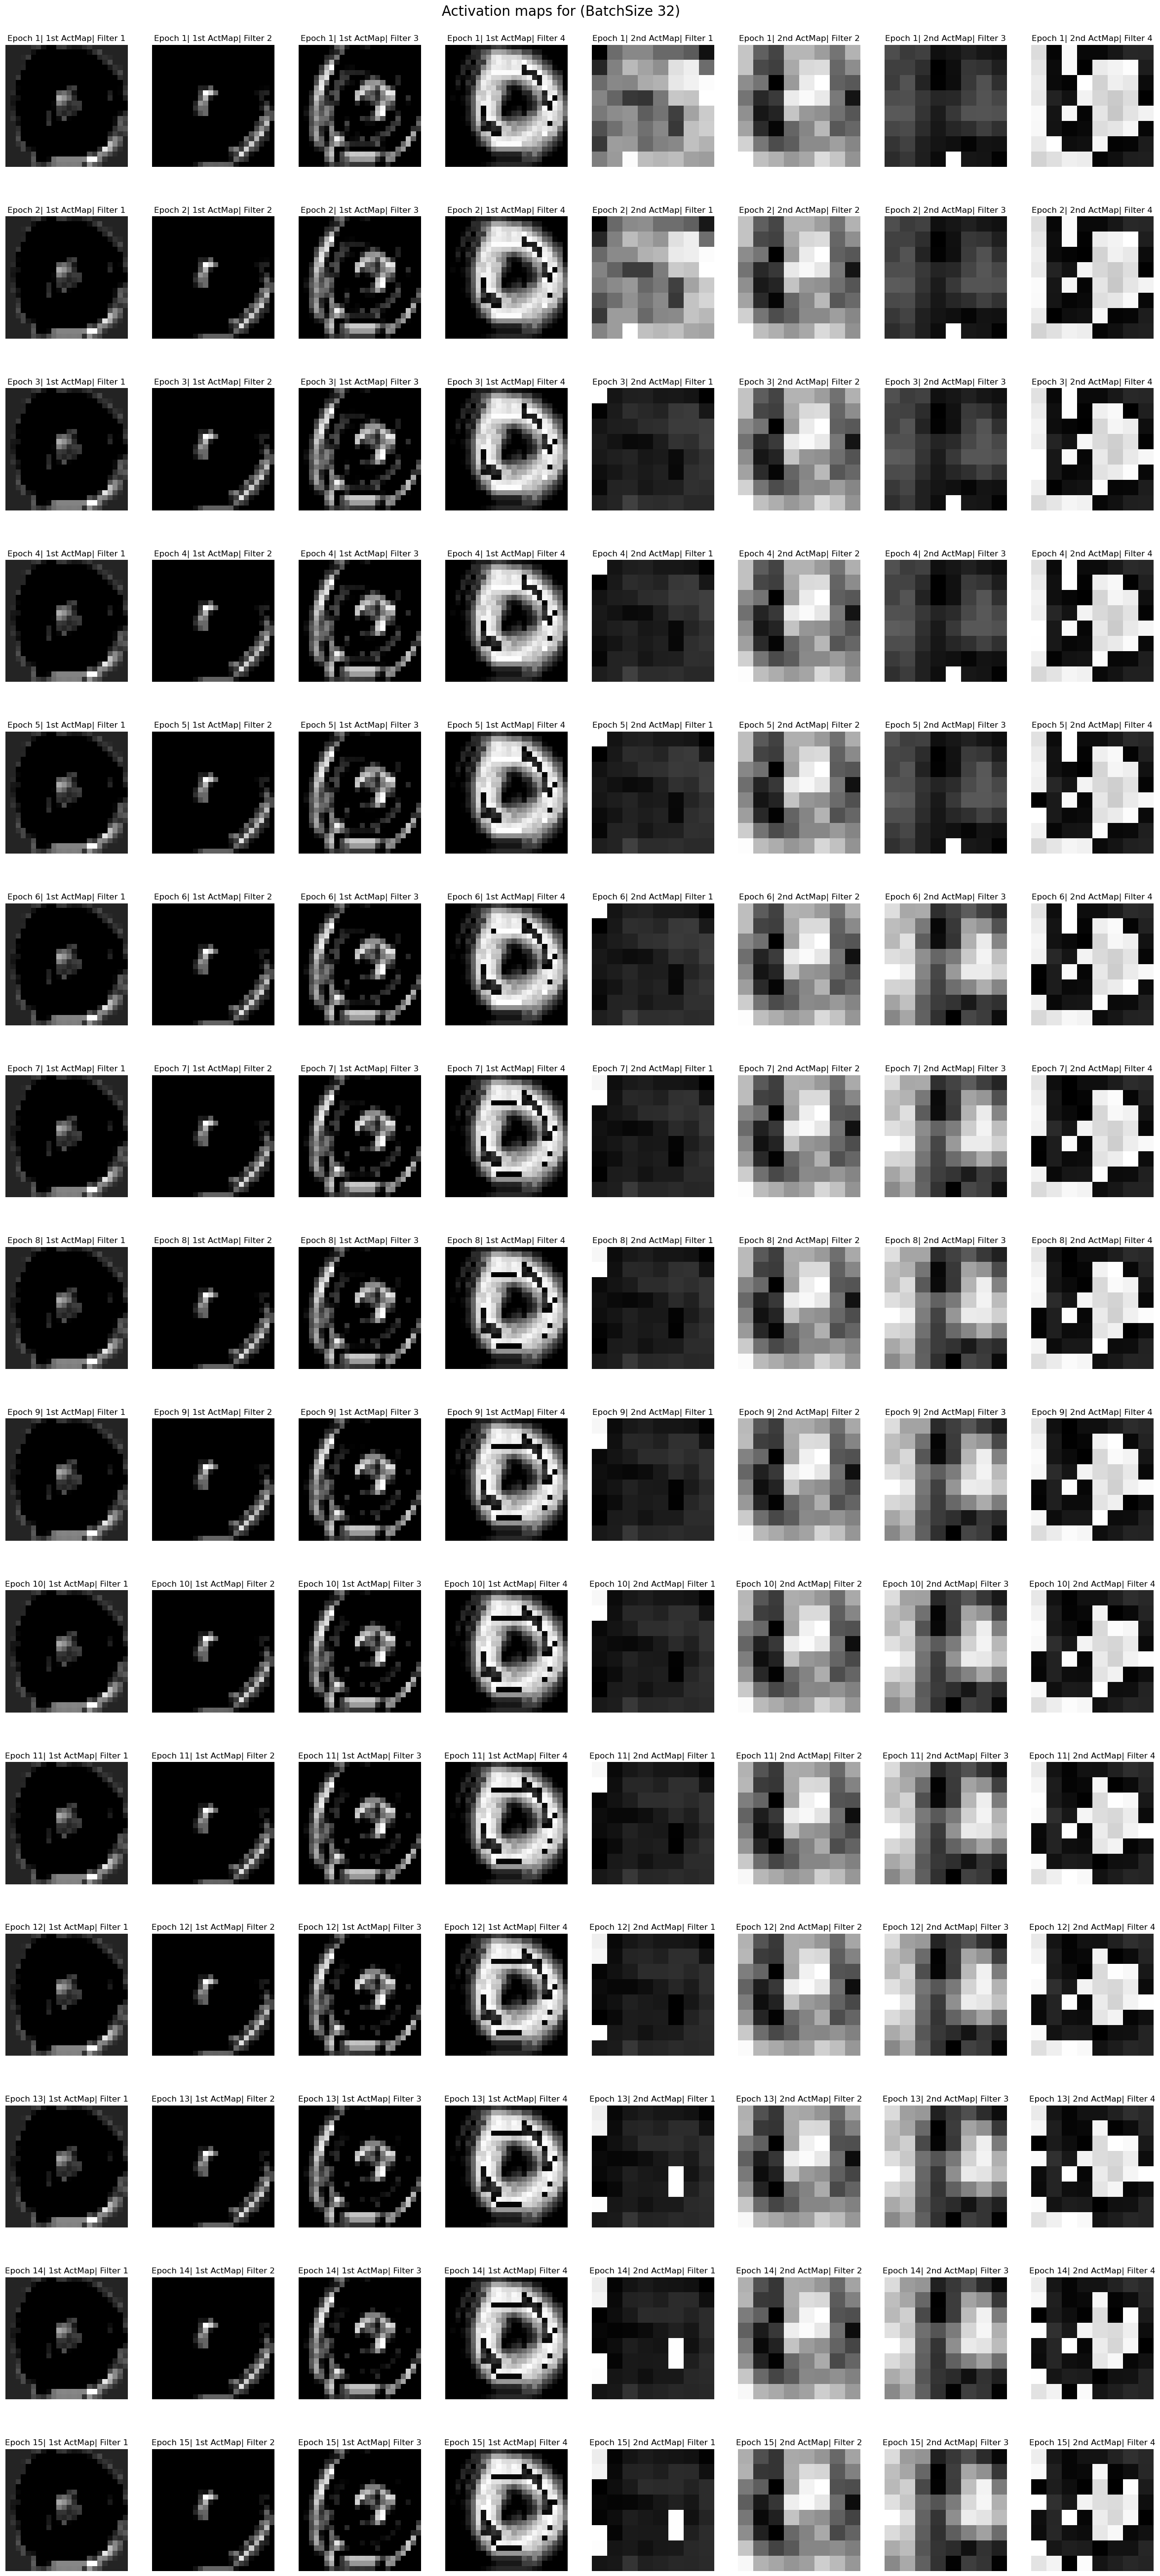

In [14]:
# Plotting the activation maps for BatchSize_32
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_32"]["activation_map1"]
activation_map2 = cache["BatchSize_32"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 32)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

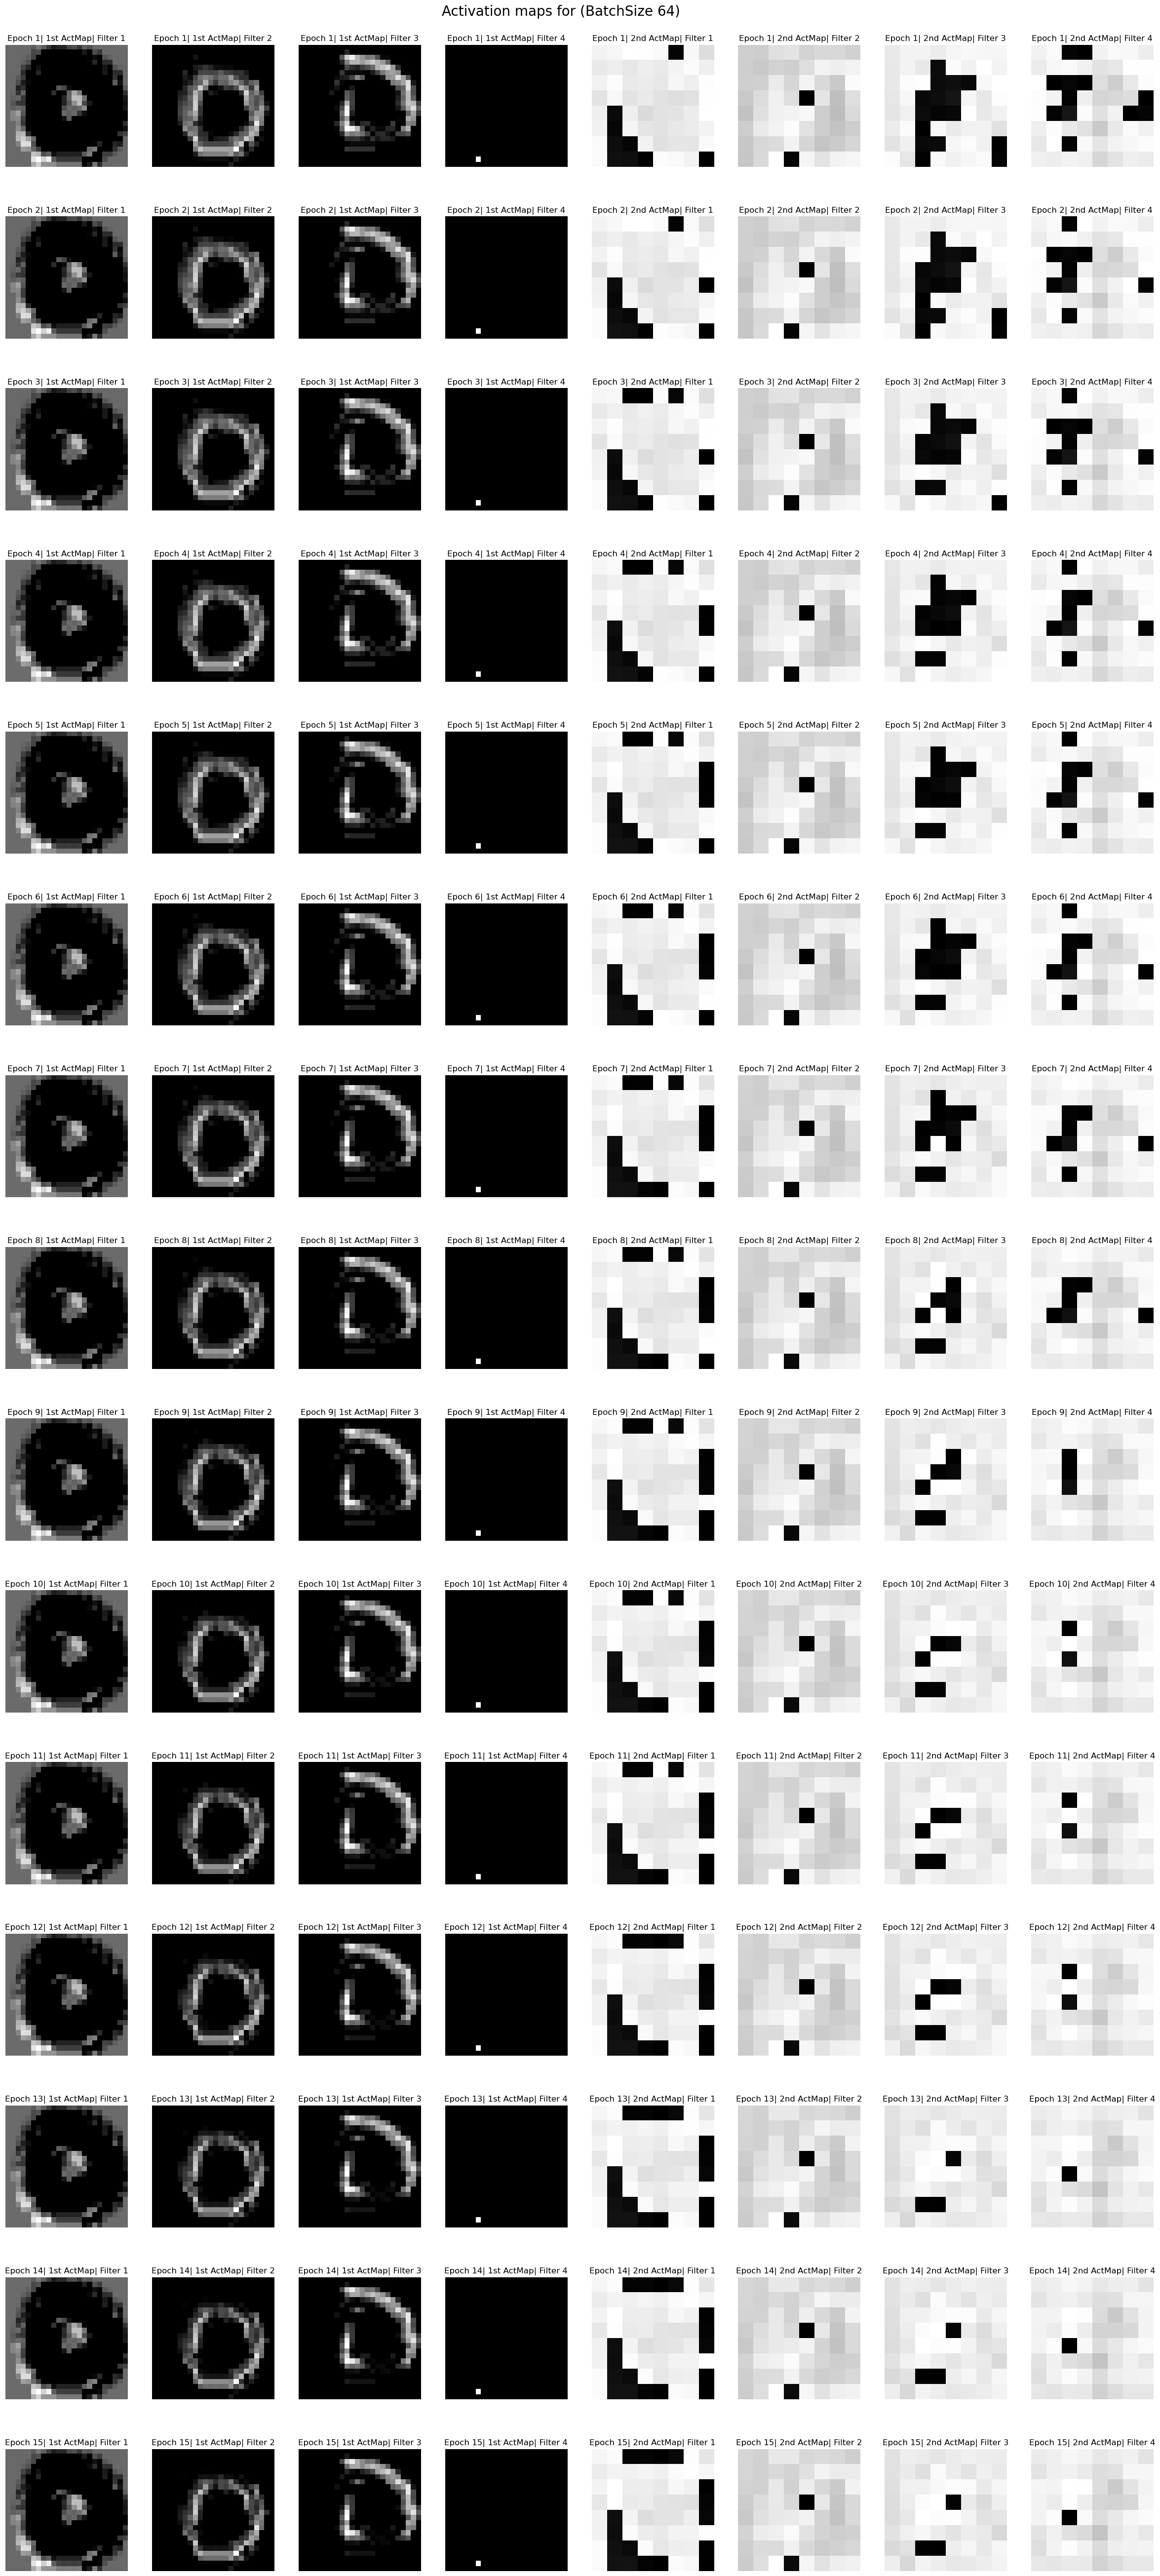

In [15]:
# Plotting the activation maps for BatchSize_64
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_64"]["activation_map1"]
activation_map2 = cache["BatchSize_64"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 64)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

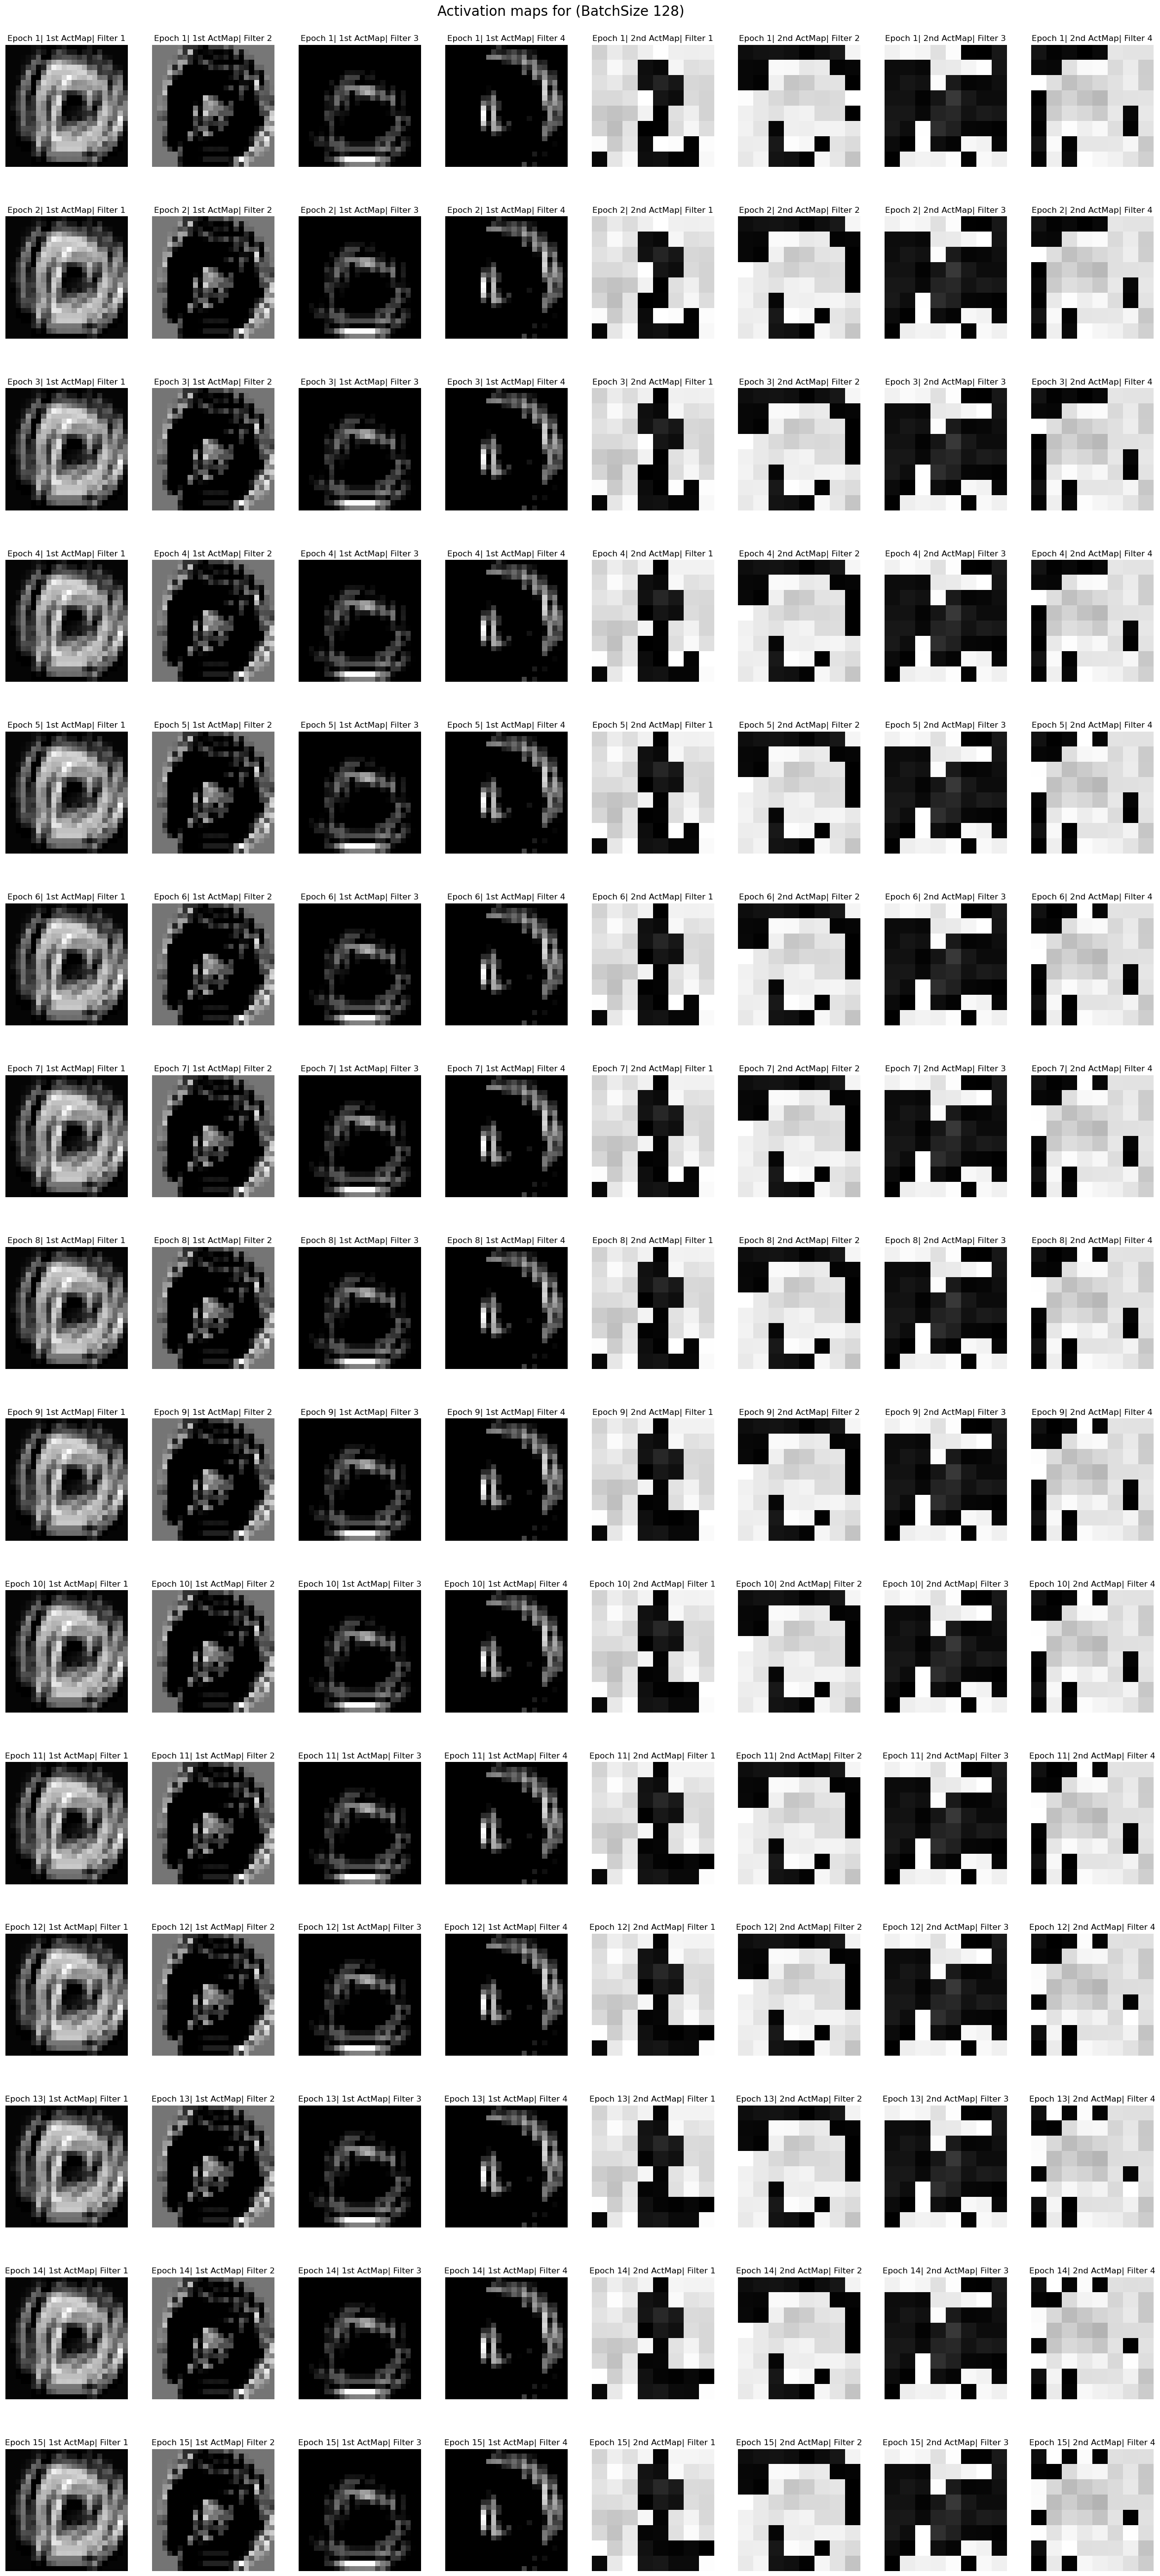

In [16]:
# Plotting the activation maps for BatchSize_128
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_128"]["activation_map1"]
activation_map2 = cache["BatchSize_128"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 128)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

### Momentum

In [17]:
cache = {}
for idx, batch in enumerate(batch_sizes):
    cache_per_batch = {}

    model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    activation_map1 = []
    activation_map2 = []

    for epoch in range(epochs):
        model.train()
        model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)
        val_loss, val_accuracy = valLoop(model, testloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        model.eval()
        with torch.no_grad():
            image, label = testset[0]
            image = image.unsqueeze(0) # Add a batch dimension
            output = model.convolution_layer1(image)
            layer1_output = output.detach().numpy().squeeze(0)

            output = model.maxpool1(output)
            output = model.convolution_layer2(output)
            layer2_output = output.detach().numpy().squeeze(0)

        layer1_output = (layer1_output * 255).astype(np.uint8)
        layer2_output = (layer2_output * 255).astype(np.uint8)

        activation_map1.append(layer1_output)
        activation_map2.append(layer2_output)
    
    cache_per_batch["train_losses"] = train_losses
    cache_per_batch["train_accuracies"] = train_accuracies
    cache_per_batch["val_losses"] = val_losses
    cache_per_batch["val_accuracies"] = val_accuracies
    cache_per_batch["activation_map1"] = activation_map1
    cache_per_batch["activation_map2"] = activation_map2

    cache[f"BatchSize_{batch}"] = cache_per_batch.copy()

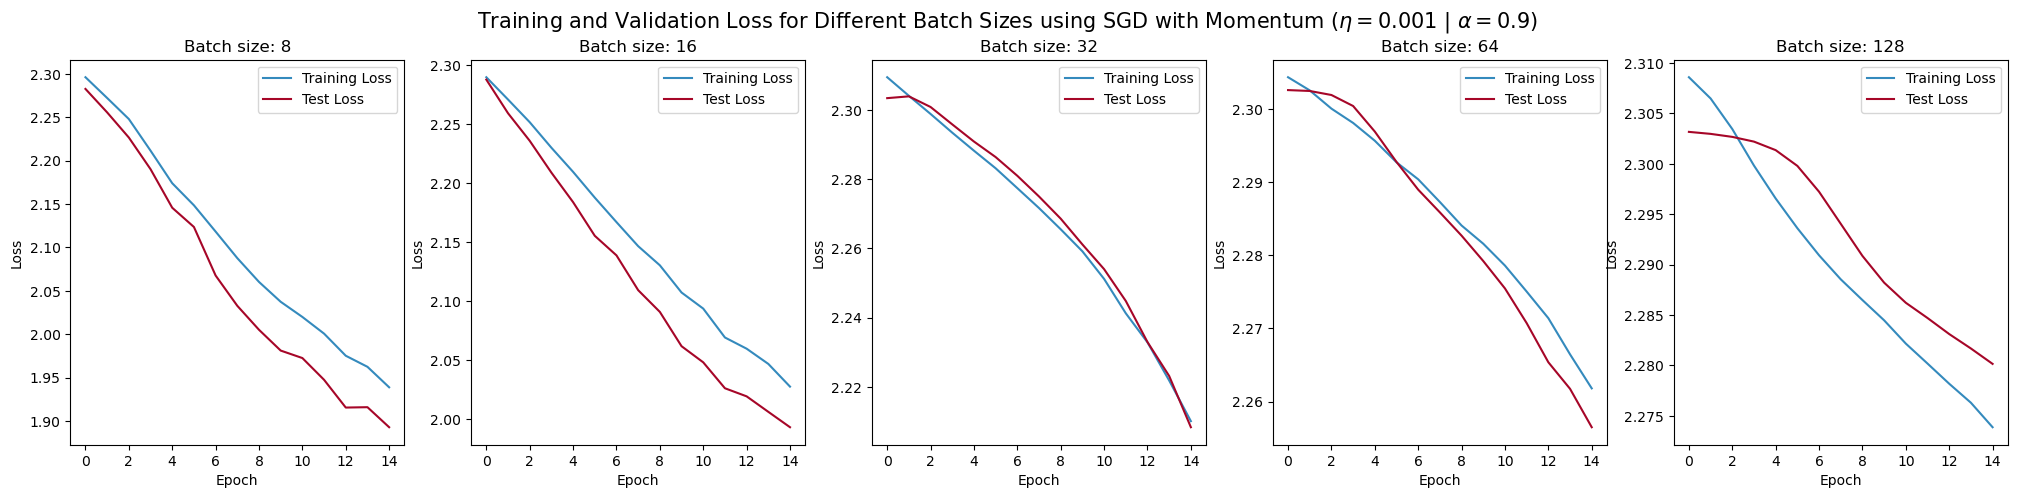

In [18]:
# Plotting the training and validation loss
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_losses = cache[key]["train_losses"]
    val_losses = cache[key]["val_losses"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_losses, label=f"Training Loss")
    plt.plot(val_losses, label=f"Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Batch size: {key.split('_')[1]}")
    plt.legend()
plt.suptitle(r"Training and Validation Loss for Different Batch Sizes using SGD with Momentum ($\eta = 0.001$ | $\alpha = 0.9$)", fontsize=15)
plt.show()

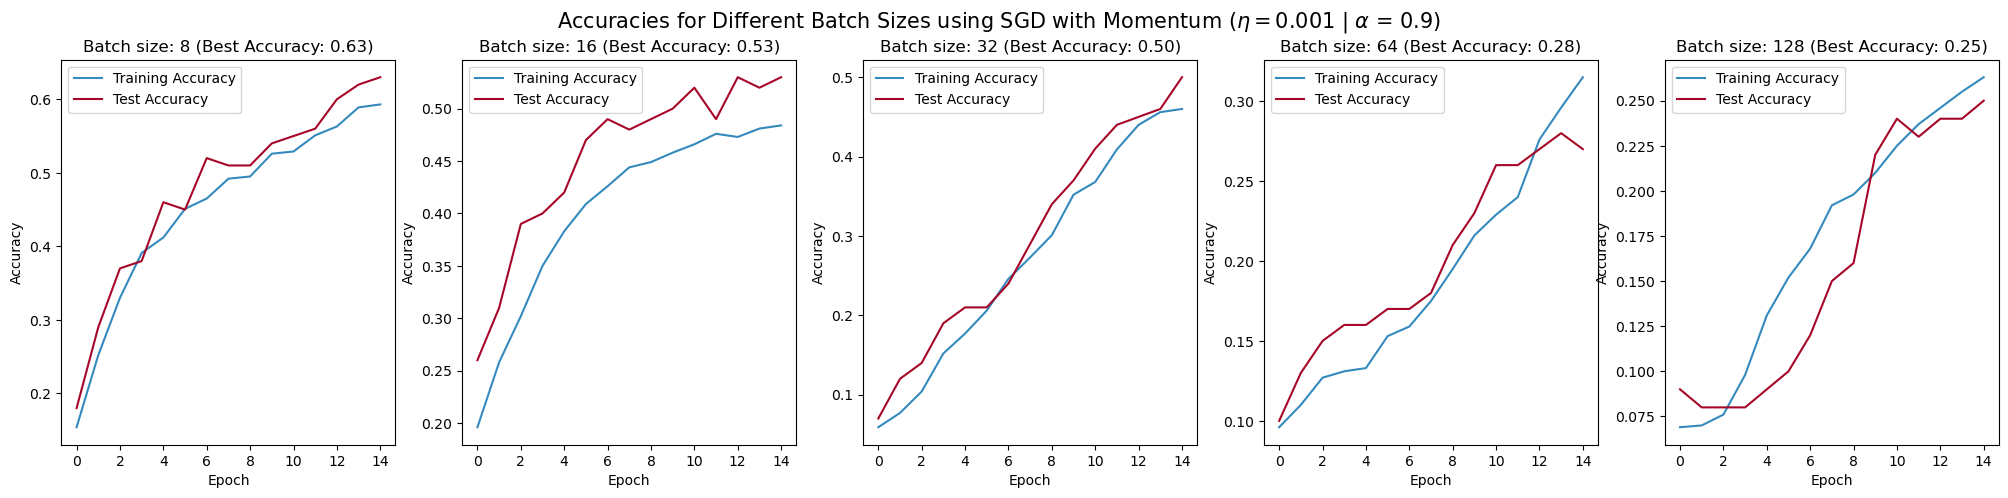

In [19]:
# Plotting the training and validation accuracy
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_accuracies = cache[key]["train_accuracies"]
    val_accuracies = cache[key]["val_accuracies"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_accuracies, label=f"Training Accuracy")
    plt.plot(val_accuracies, label=f"Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Batch size: {key.split('_')[1]} (Best Accuracy: {max(val_accuracies):.2f})")
    plt.legend()
plt.suptitle(r"Accuracies for Different Batch Sizes using SGD with Momentum ($\eta = 0.001$ | $\alpha$ = 0.9)", fontsize=15)
plt.show()

### Plotting Activation Maps for SGD with Momentum

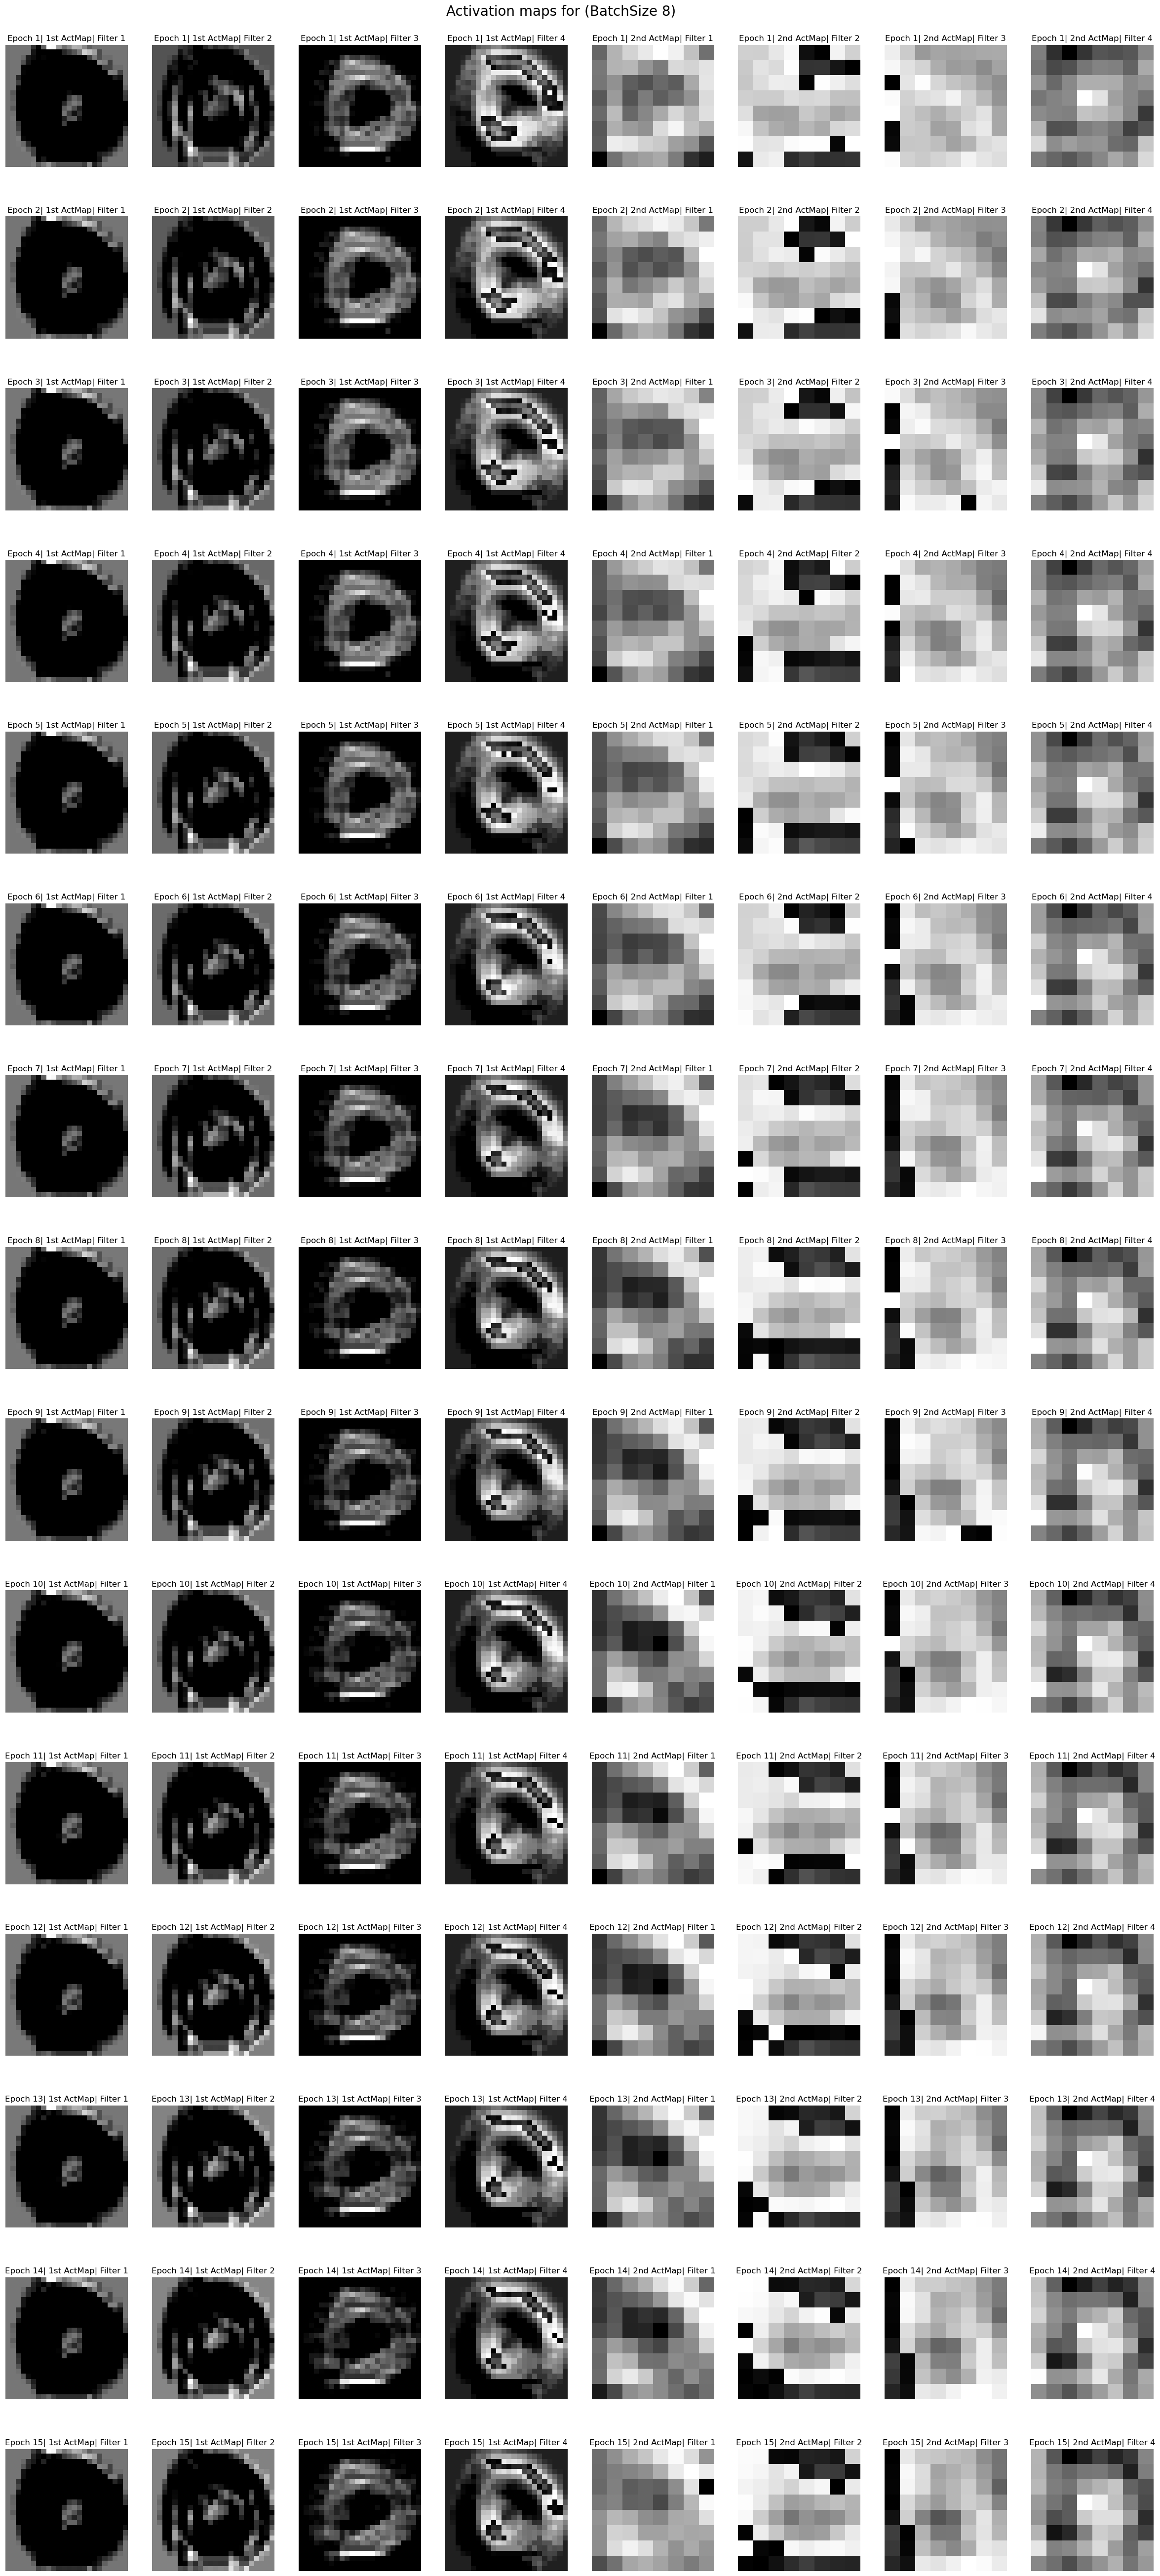

In [20]:
# Plotting the activation maps for BatchSize_8
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_8"]["activation_map1"]
activation_map2 = cache["BatchSize_8"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 8)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

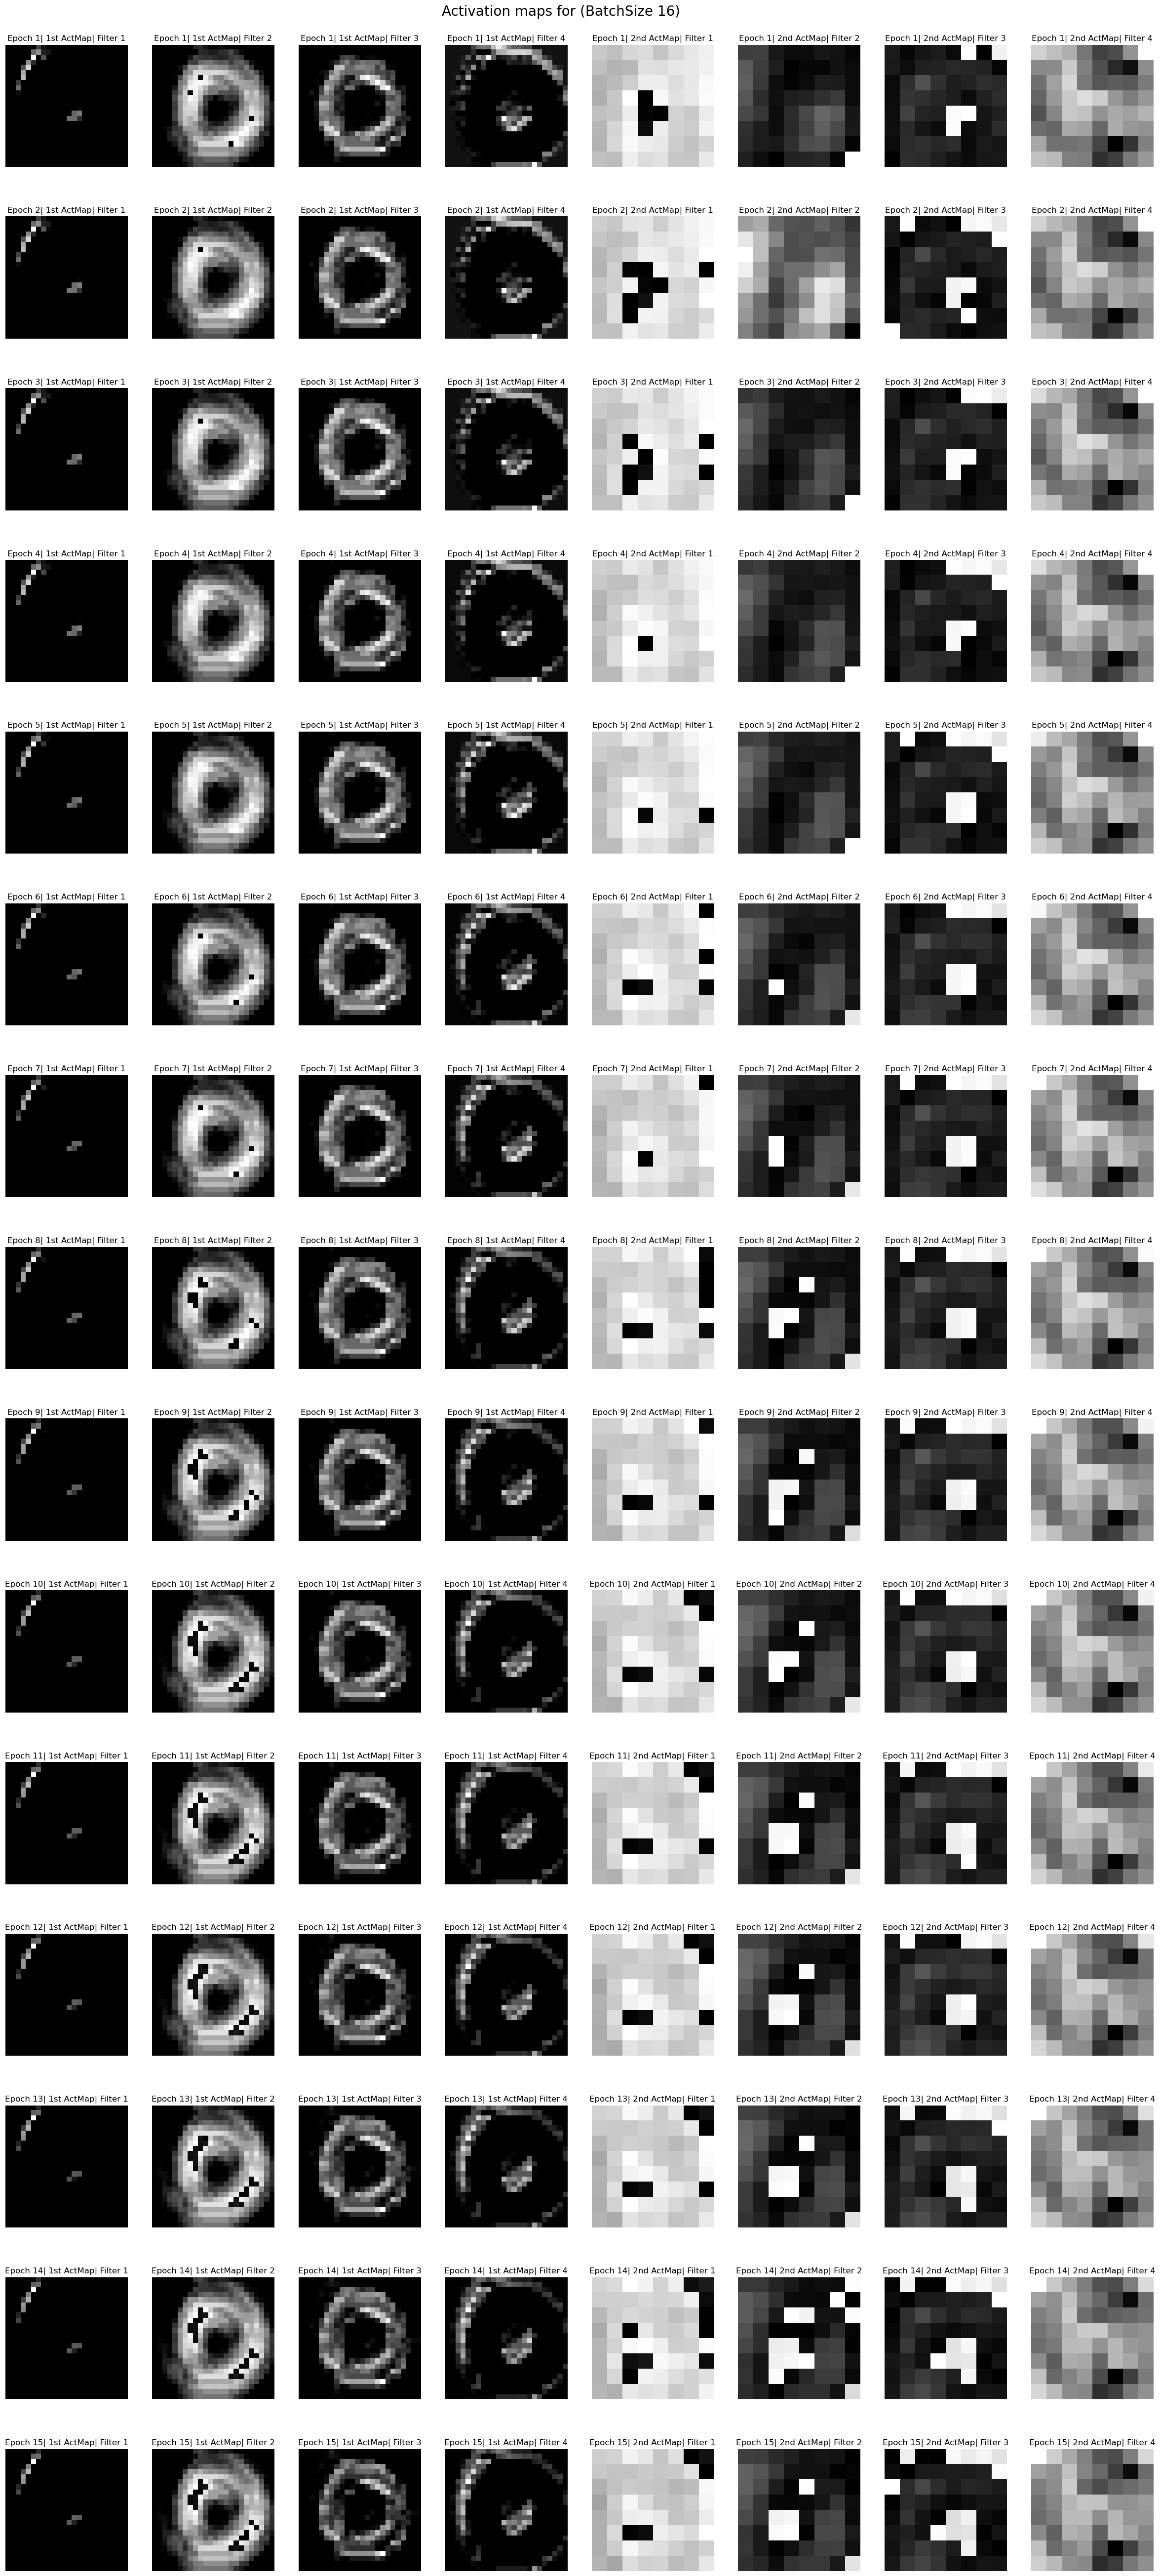

In [21]:
# Plotting the activation maps for BatchSize_16
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_16"]["activation_map1"]
activation_map2 = cache["BatchSize_16"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 16)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

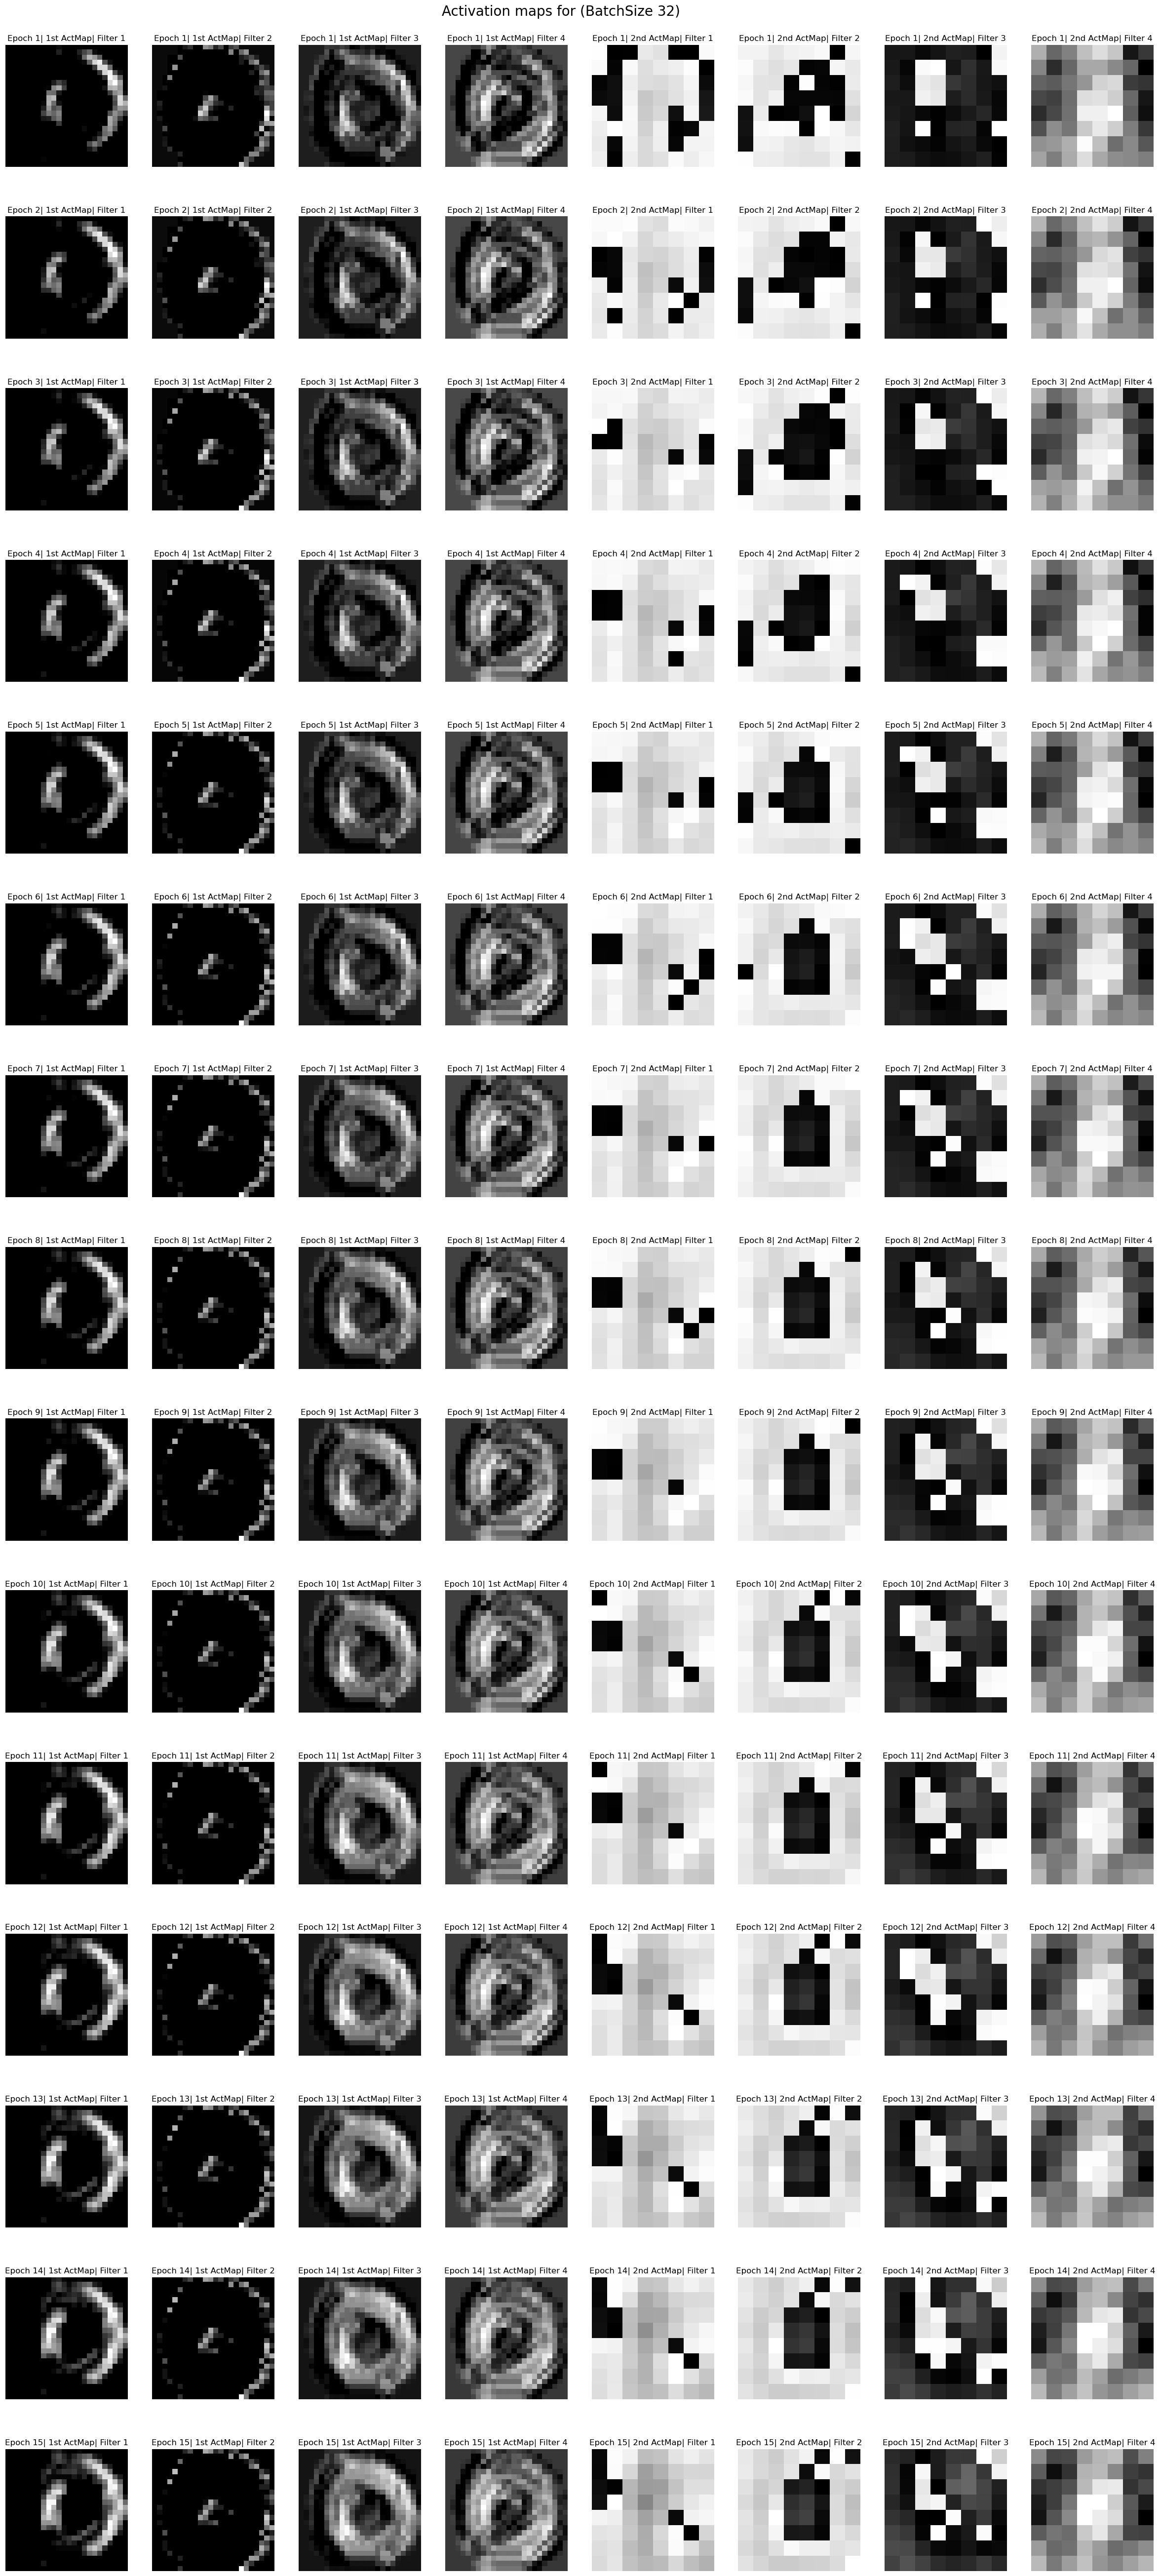

In [22]:
# Plotting the activation maps for BatchSize_32
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_32"]["activation_map1"]
activation_map2 = cache["BatchSize_32"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 32)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

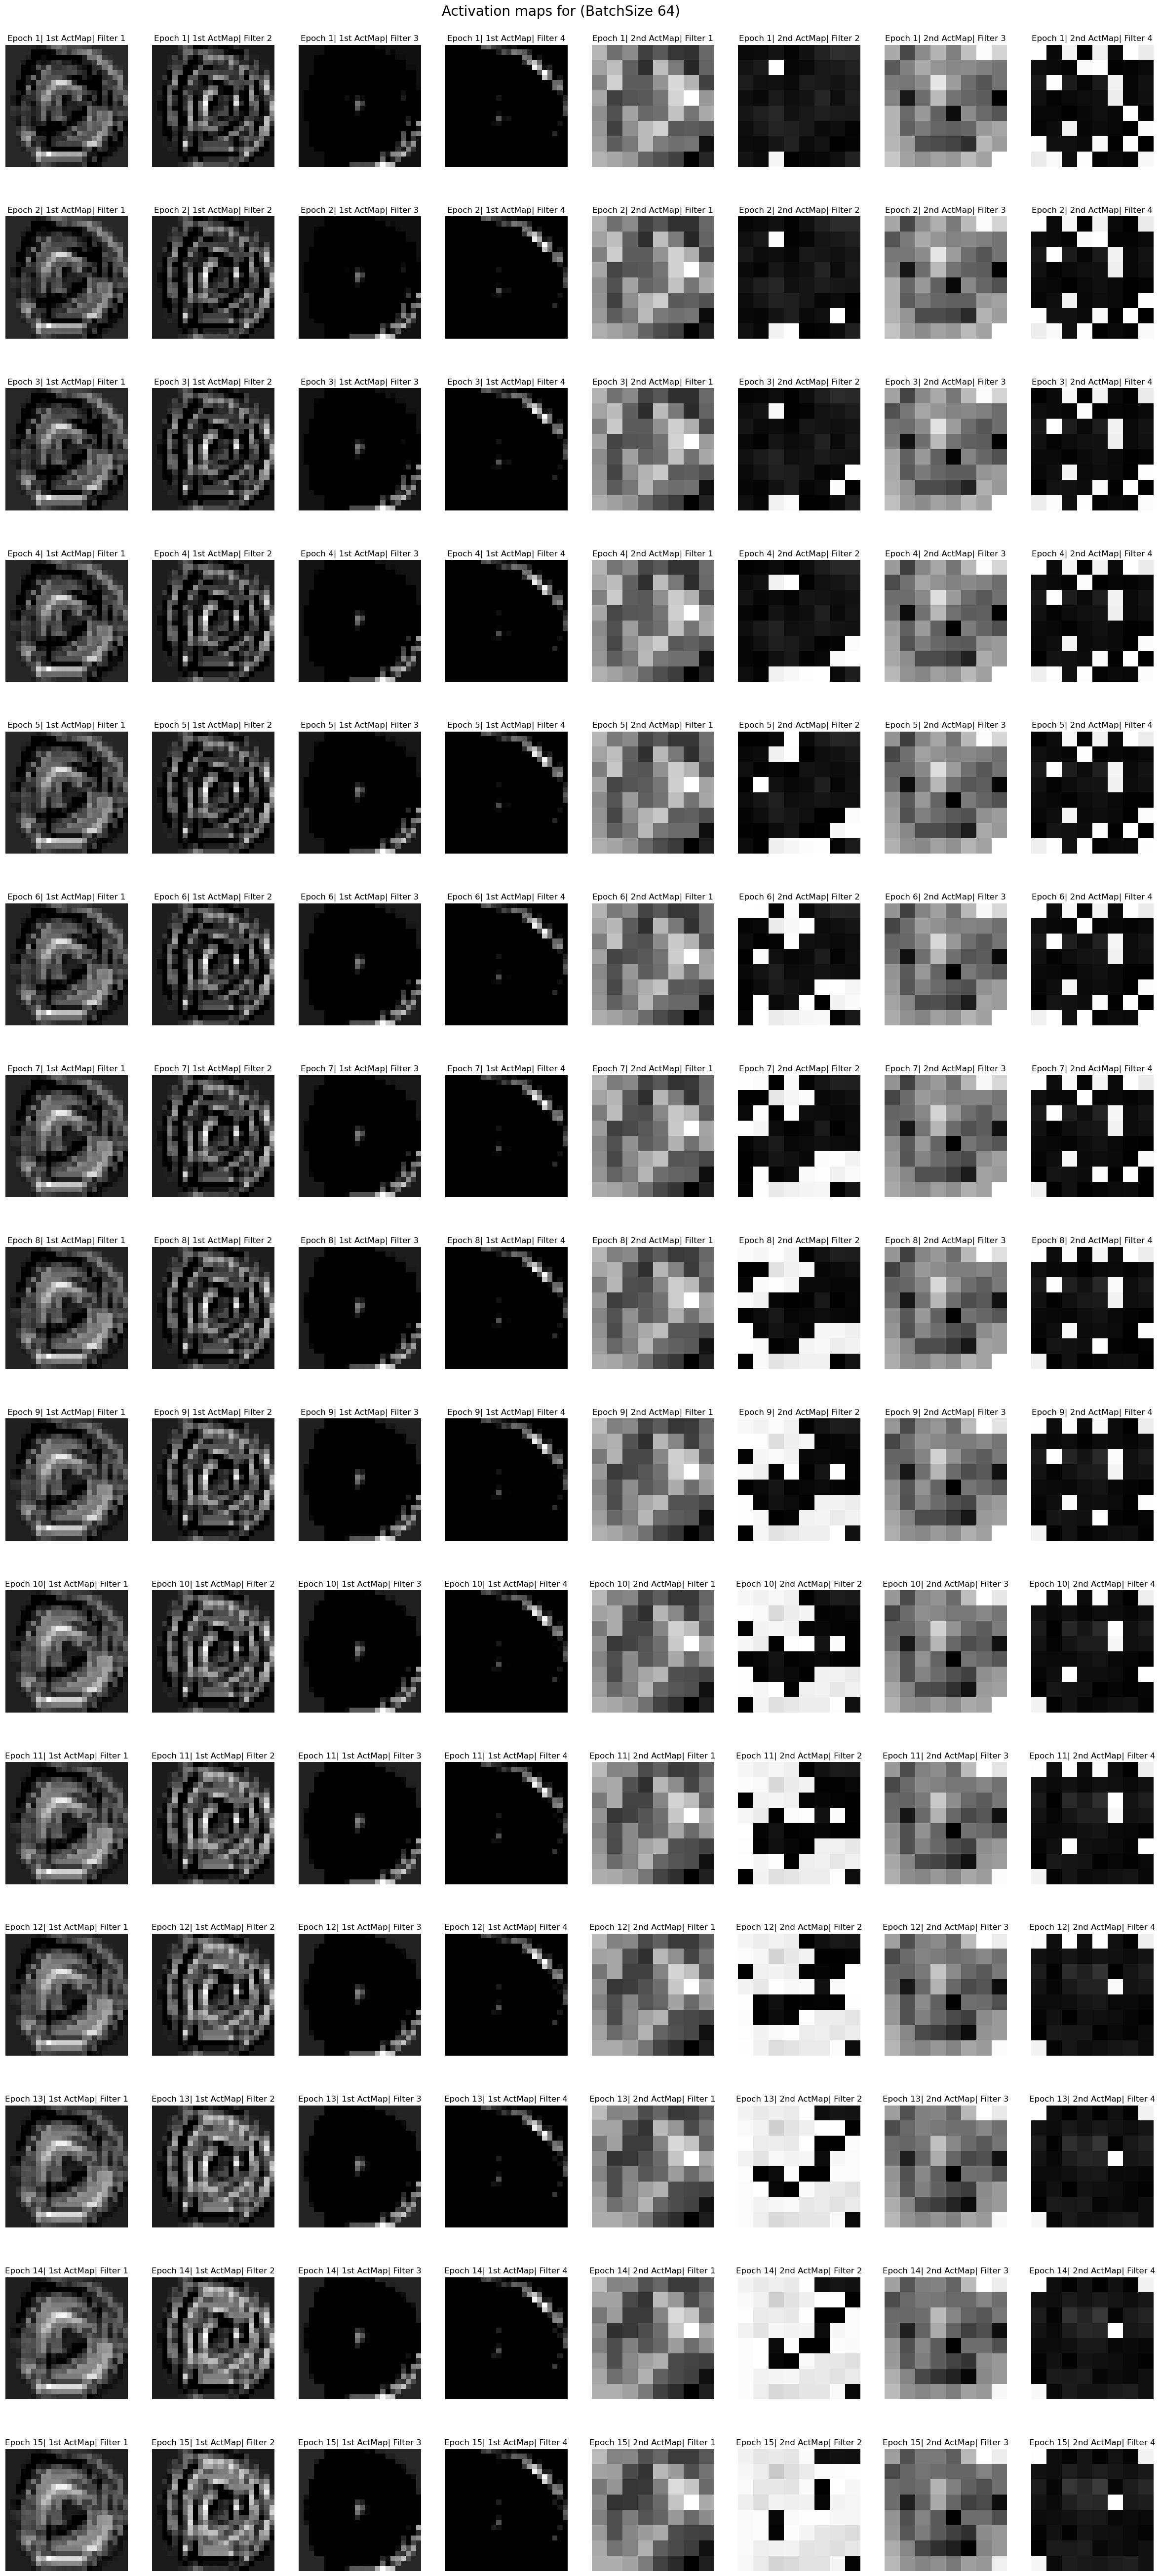

In [23]:
# Plotting the activation maps for BatchSize_64
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_64"]["activation_map1"]
activation_map2 = cache["BatchSize_64"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 64)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

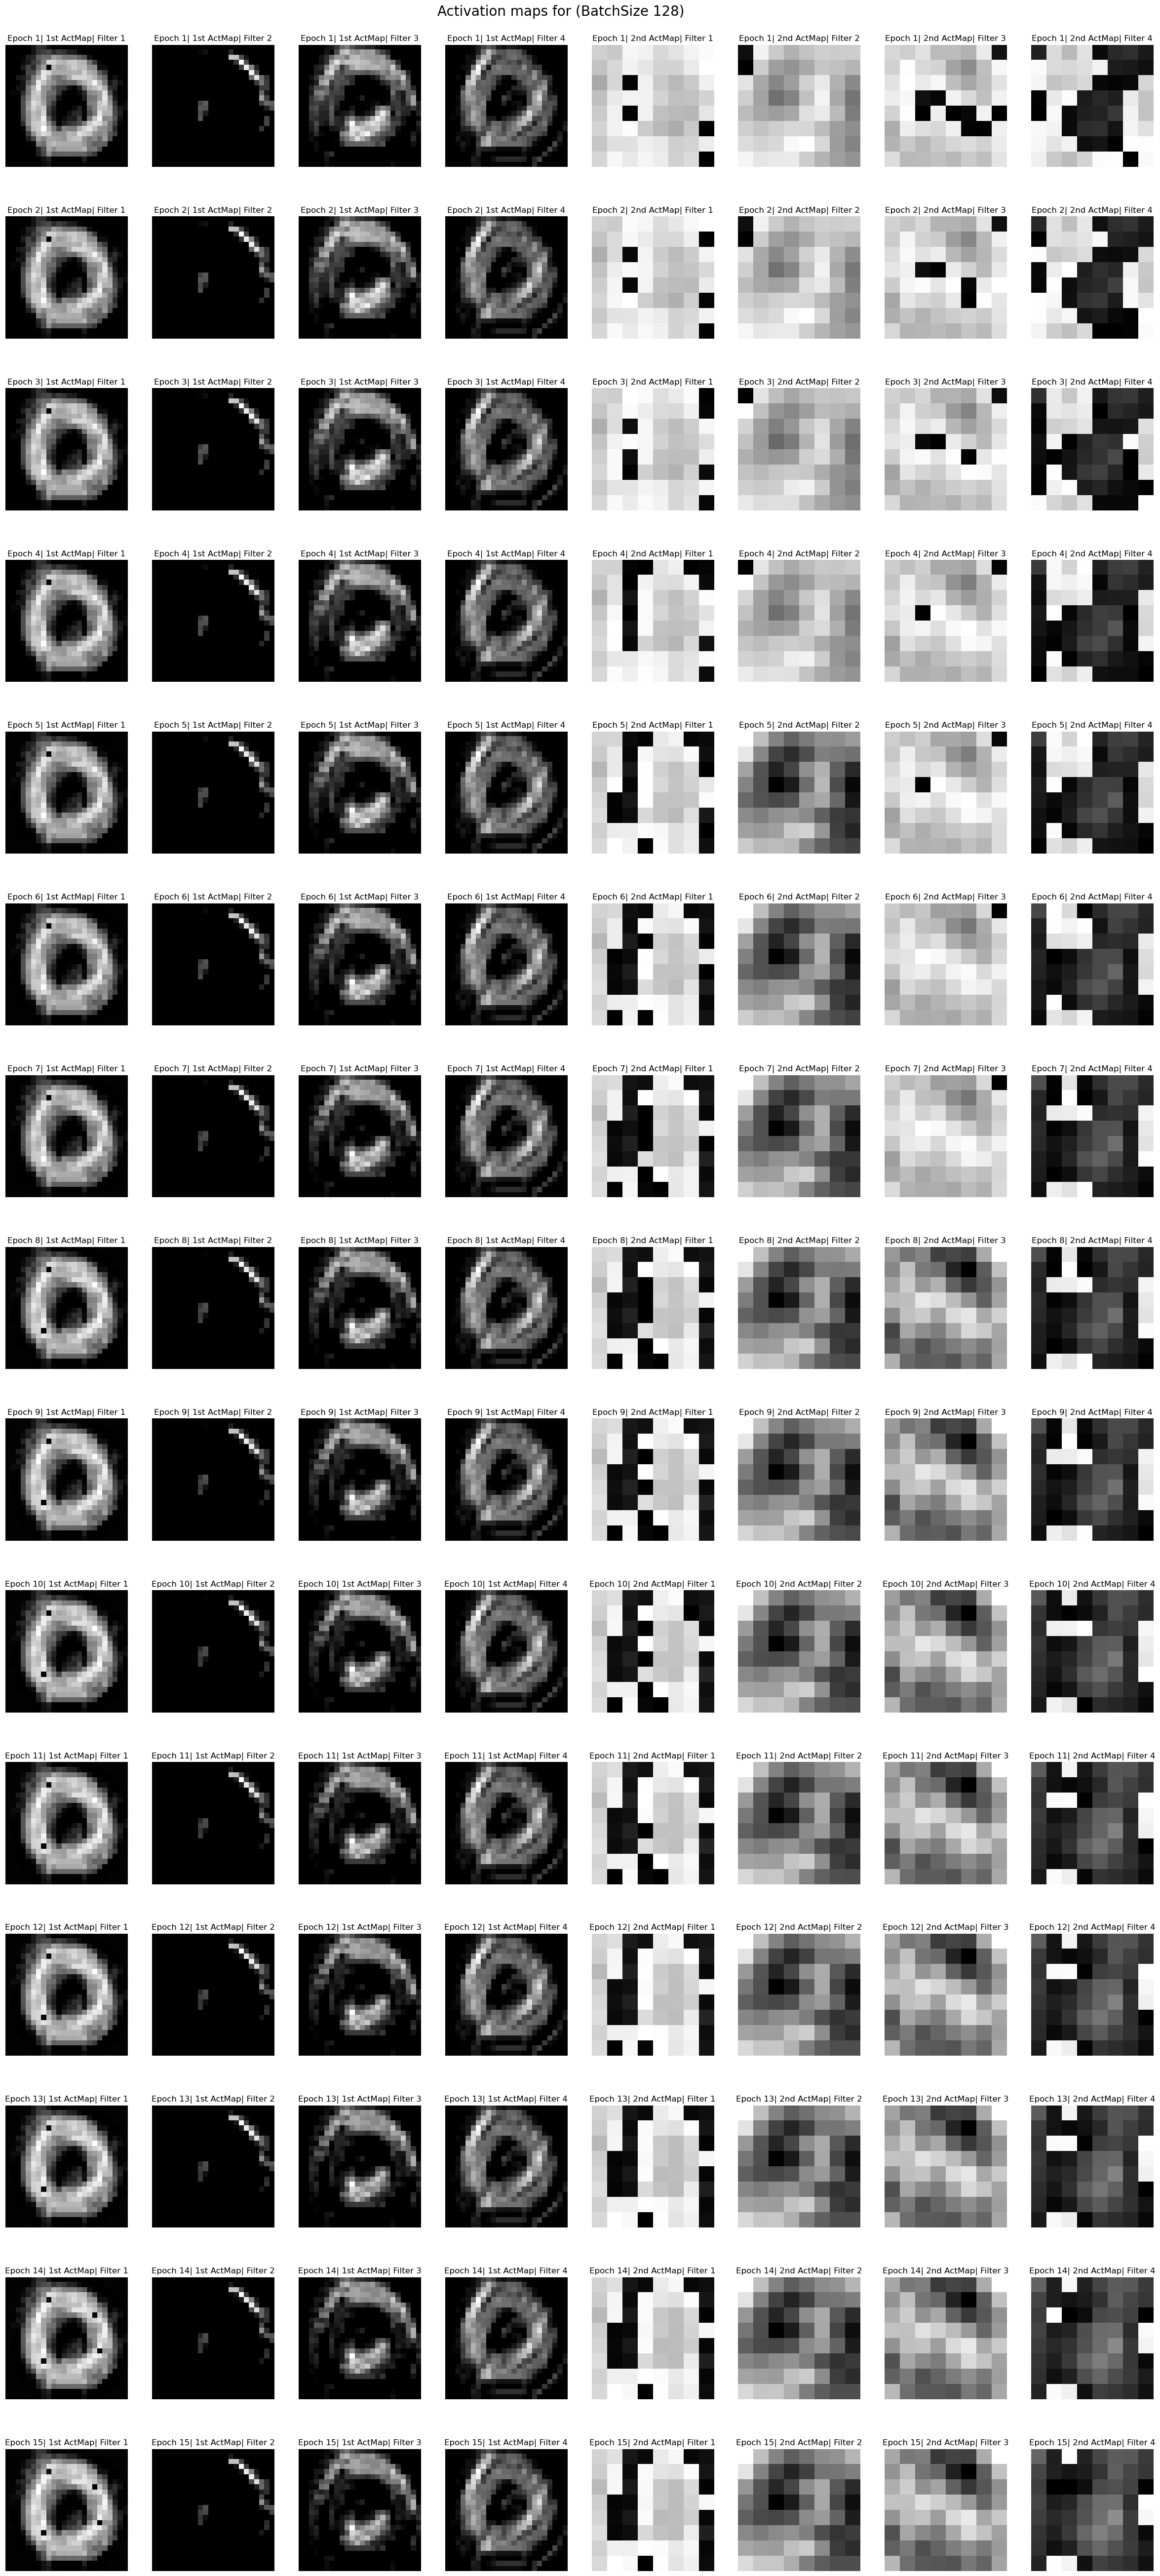

In [24]:
# Plotting the activation maps for BatchSize_128
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_128"]["activation_map1"]
activation_map2 = cache["BatchSize_128"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 128)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

### RMSProp

In [25]:
cache = {}
for idx, batch in enumerate(batch_sizes):
    cache_per_batch = {}

    model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    activation_map1 = []
    activation_map2 = []

    for epoch in range(epochs):
        model.train()
        model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)
        val_loss, val_accuracy = valLoop(model, testloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        model.eval()
        with torch.no_grad():
            image, label = testset[0]
            image = image.unsqueeze(0) # Add a batch dimension
            output = model.convolution_layer1(image)
            layer1_output = output.detach().numpy().squeeze(0)

            output = model.maxpool1(output)
            output = model.convolution_layer2(output)
            layer2_output = output.detach().numpy().squeeze(0)

        layer1_output = (layer1_output * 255).astype(np.uint8)
        layer2_output = (layer2_output * 255).astype(np.uint8)

        activation_map1.append(layer1_output)
        activation_map2.append(layer2_output)
    
    cache_per_batch["train_losses"] = train_losses
    cache_per_batch["train_accuracies"] = train_accuracies
    cache_per_batch["val_losses"] = val_losses
    cache_per_batch["val_accuracies"] = val_accuracies
    cache_per_batch["activation_map1"] = activation_map1
    cache_per_batch["activation_map2"] = activation_map2

    cache[f"BatchSize_{batch}"] = cache_per_batch.copy()

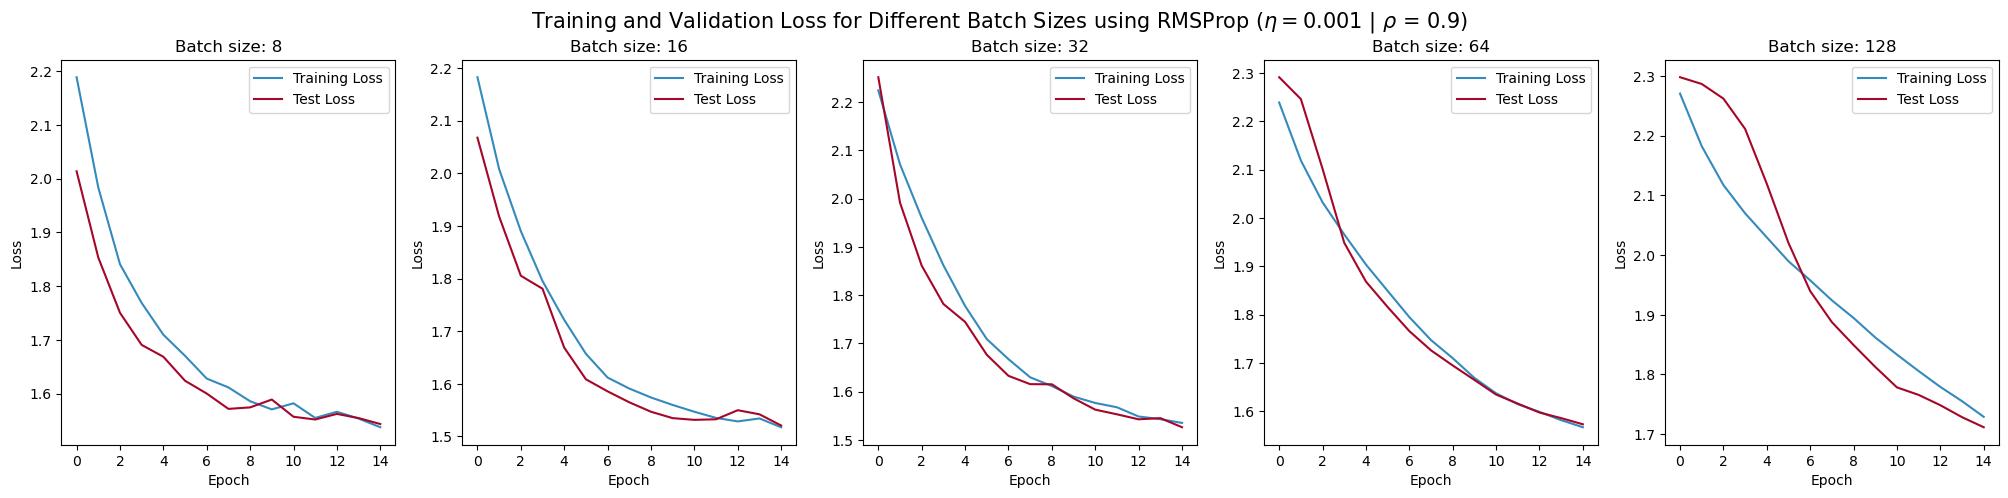

In [26]:
# Plotting the training and validation loss
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_losses = cache[key]["train_losses"]
    val_losses = cache[key]["val_losses"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_losses, label=f"Training Loss")
    plt.plot(val_losses, label=f"Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Batch size: {key.split('_')[1]}")
    plt.legend()
plt.suptitle(r"Training and Validation Loss for Different Batch Sizes using RMSProp ($\eta = 0.001$ | $\rho$ = 0.9)", fontsize=15)
plt.show()

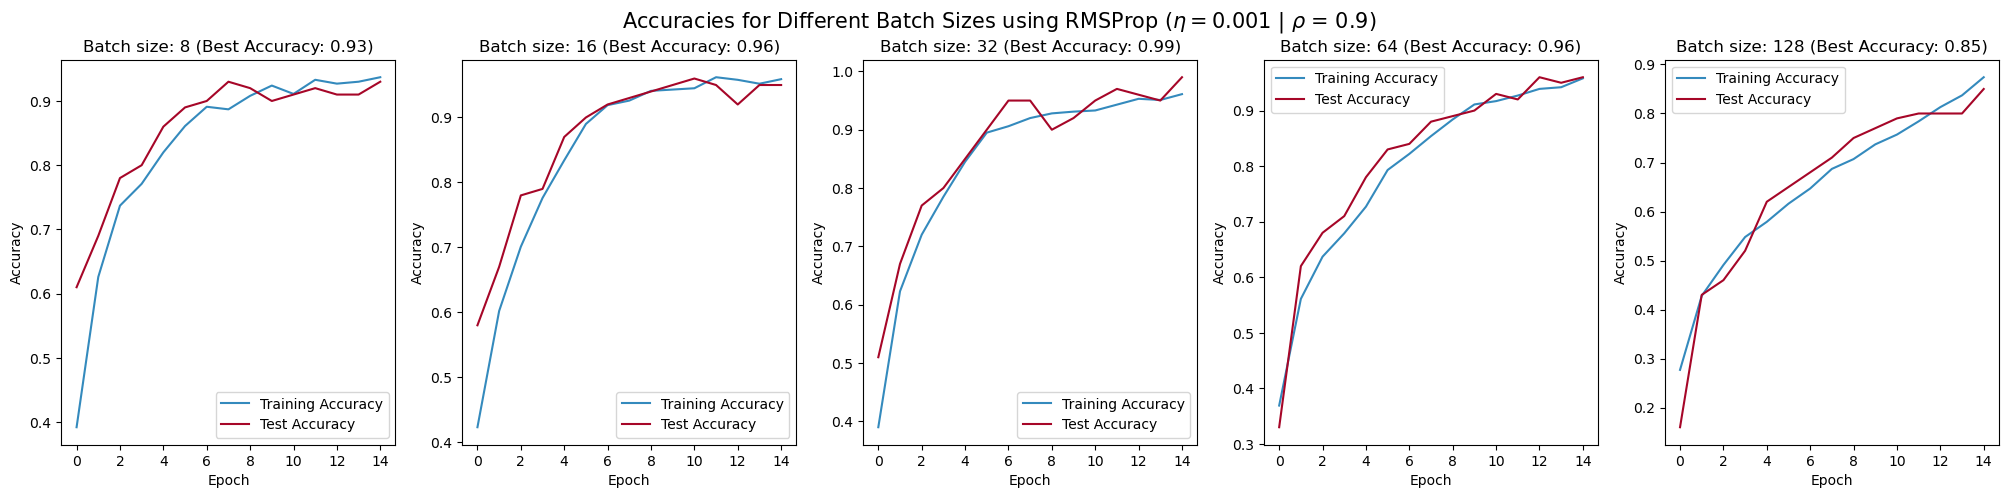

In [27]:
# Plotting the training and validation accuracy
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_accuracies = cache[key]["train_accuracies"]
    val_accuracies = cache[key]["val_accuracies"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_accuracies, label=f"Training Accuracy")
    plt.plot(val_accuracies, label=f"Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Batch size: {key.split('_')[1]} (Best Accuracy: {max(val_accuracies):.2f})")
    plt.legend()
plt.suptitle(r"Accuracies for Different Batch Sizes using RMSProp ($\eta = 0.001$ | $\rho$ = 0.9)", fontsize=15)
plt.show()

### Plotting Activation Maps for RMSProp

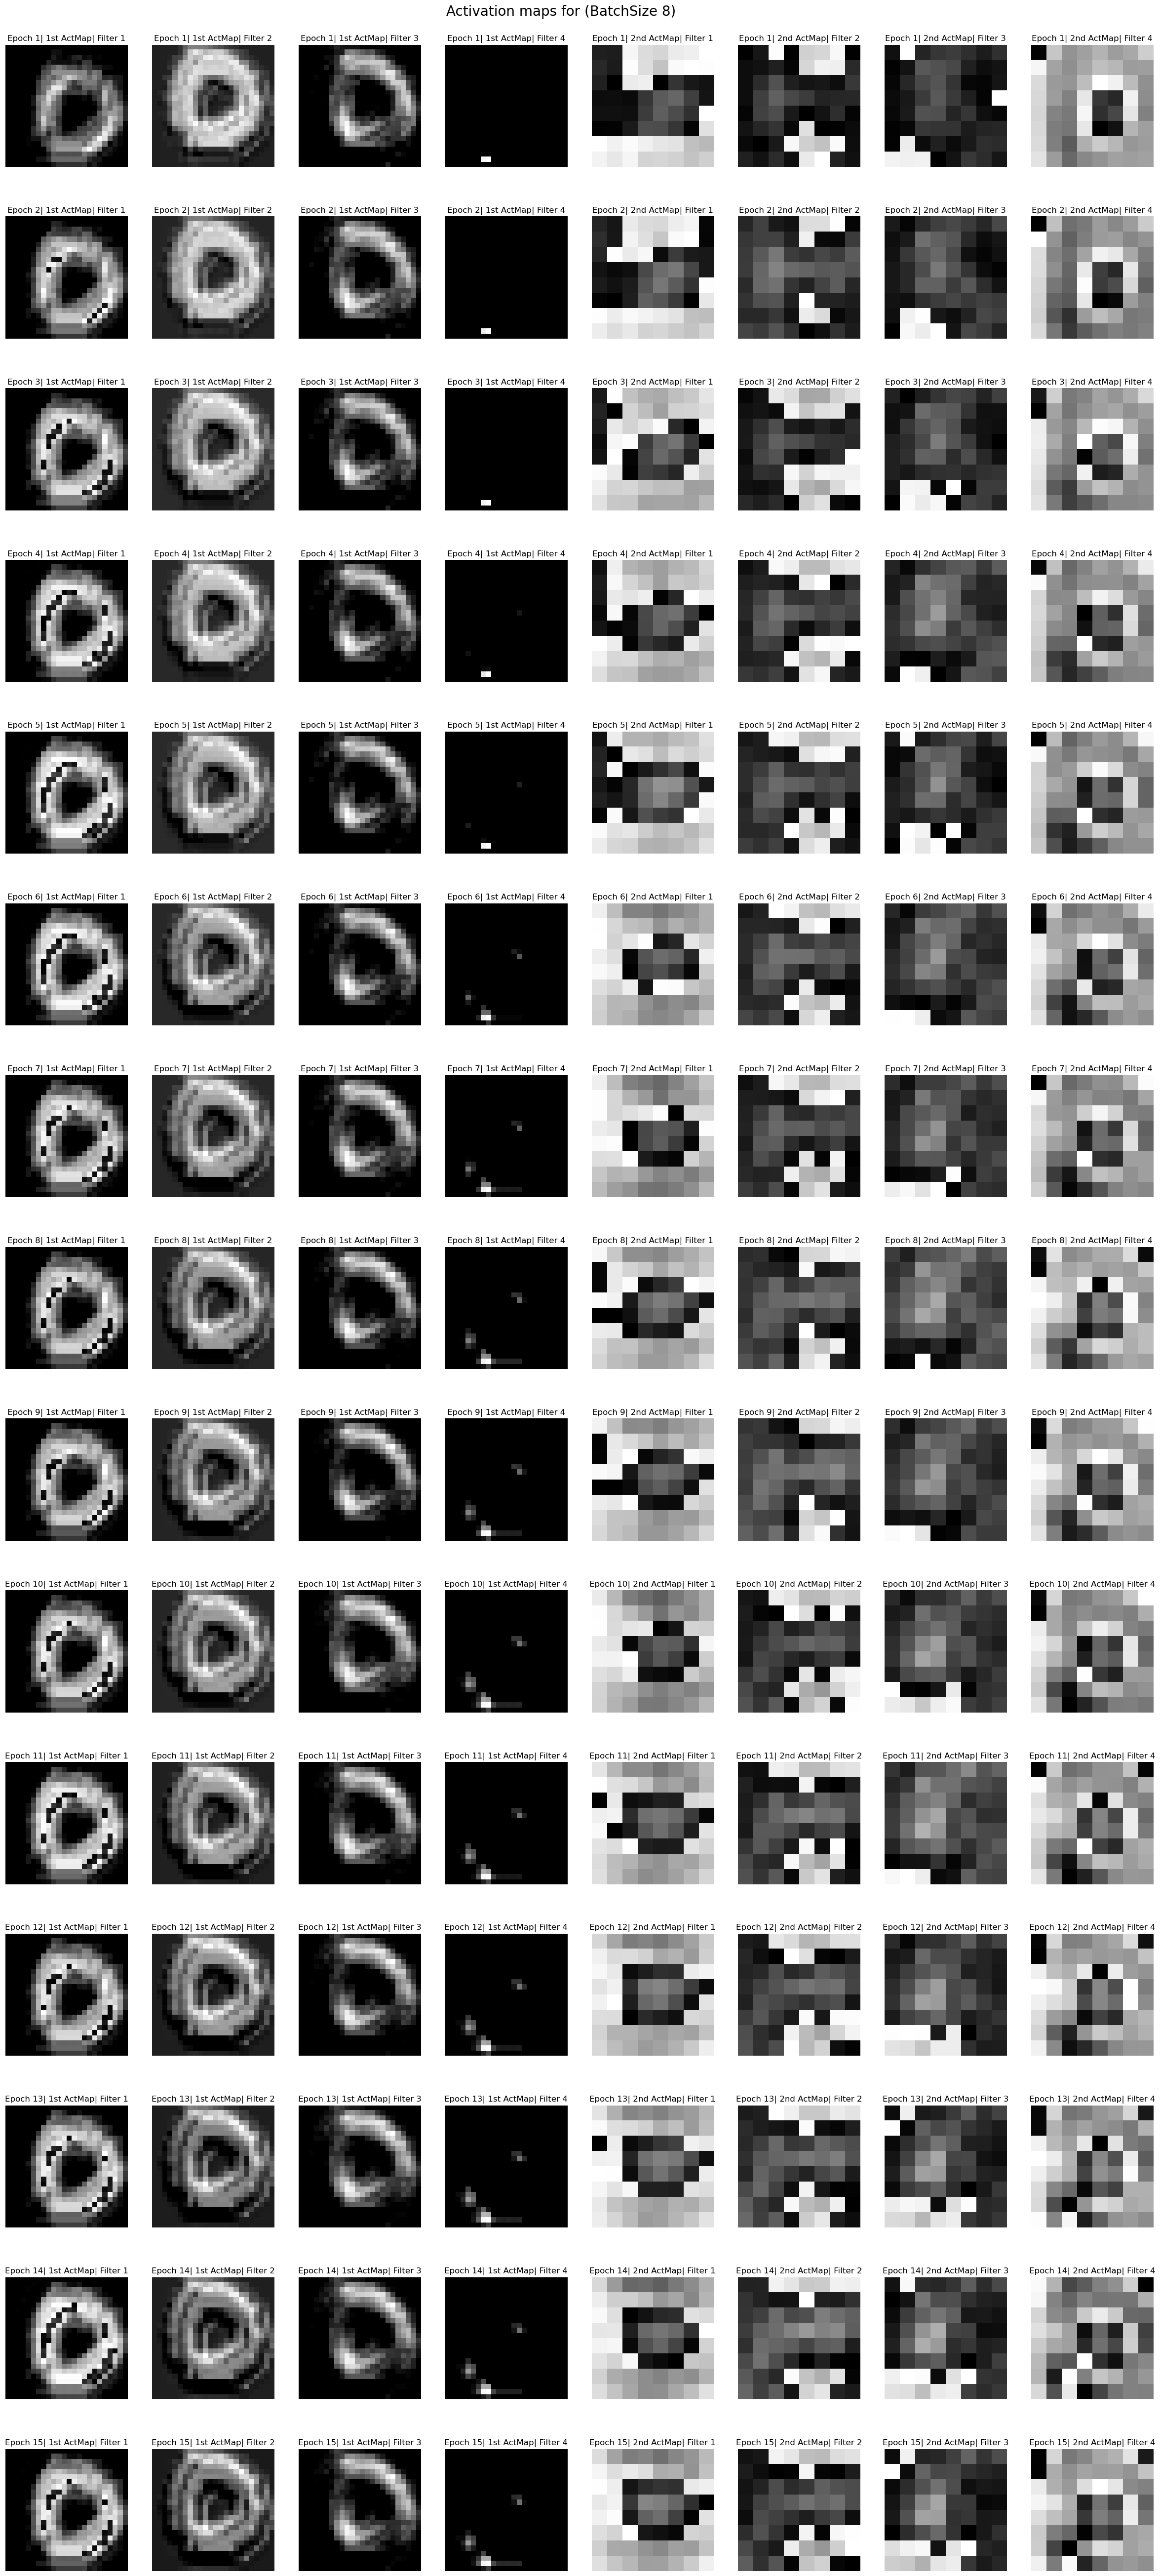

In [28]:
# Plotting the activation maps for BatchSize_8
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_8"]["activation_map1"]
activation_map2 = cache["BatchSize_8"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 8)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

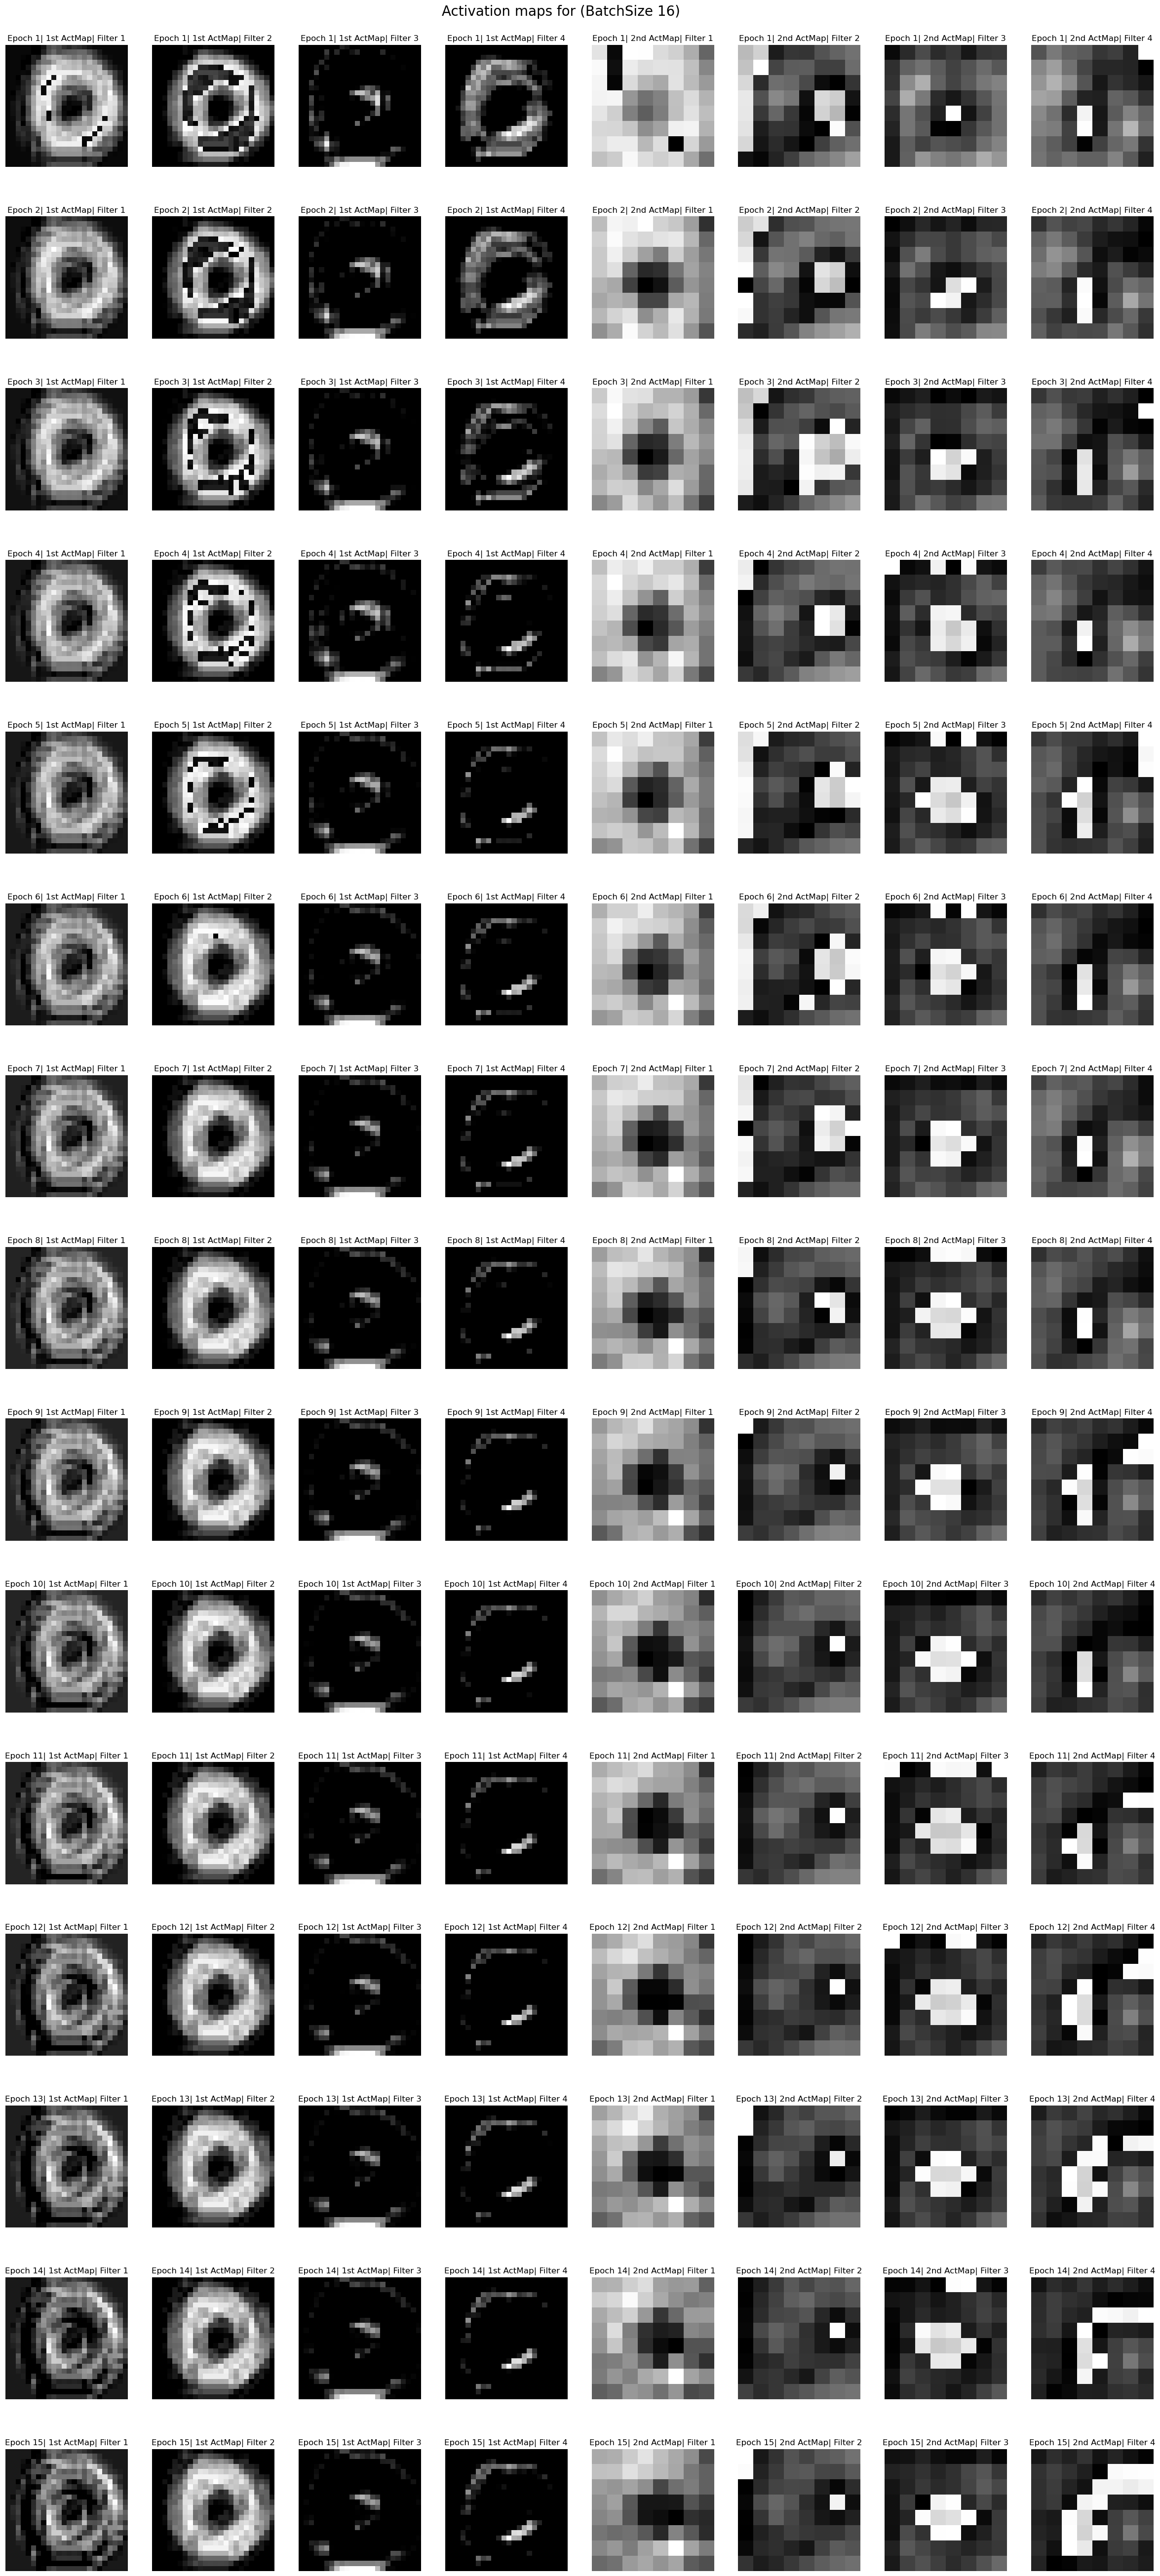

In [29]:
# Plotting the activation maps for BatchSize_16
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_16"]["activation_map1"]
activation_map2 = cache["BatchSize_16"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 16)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

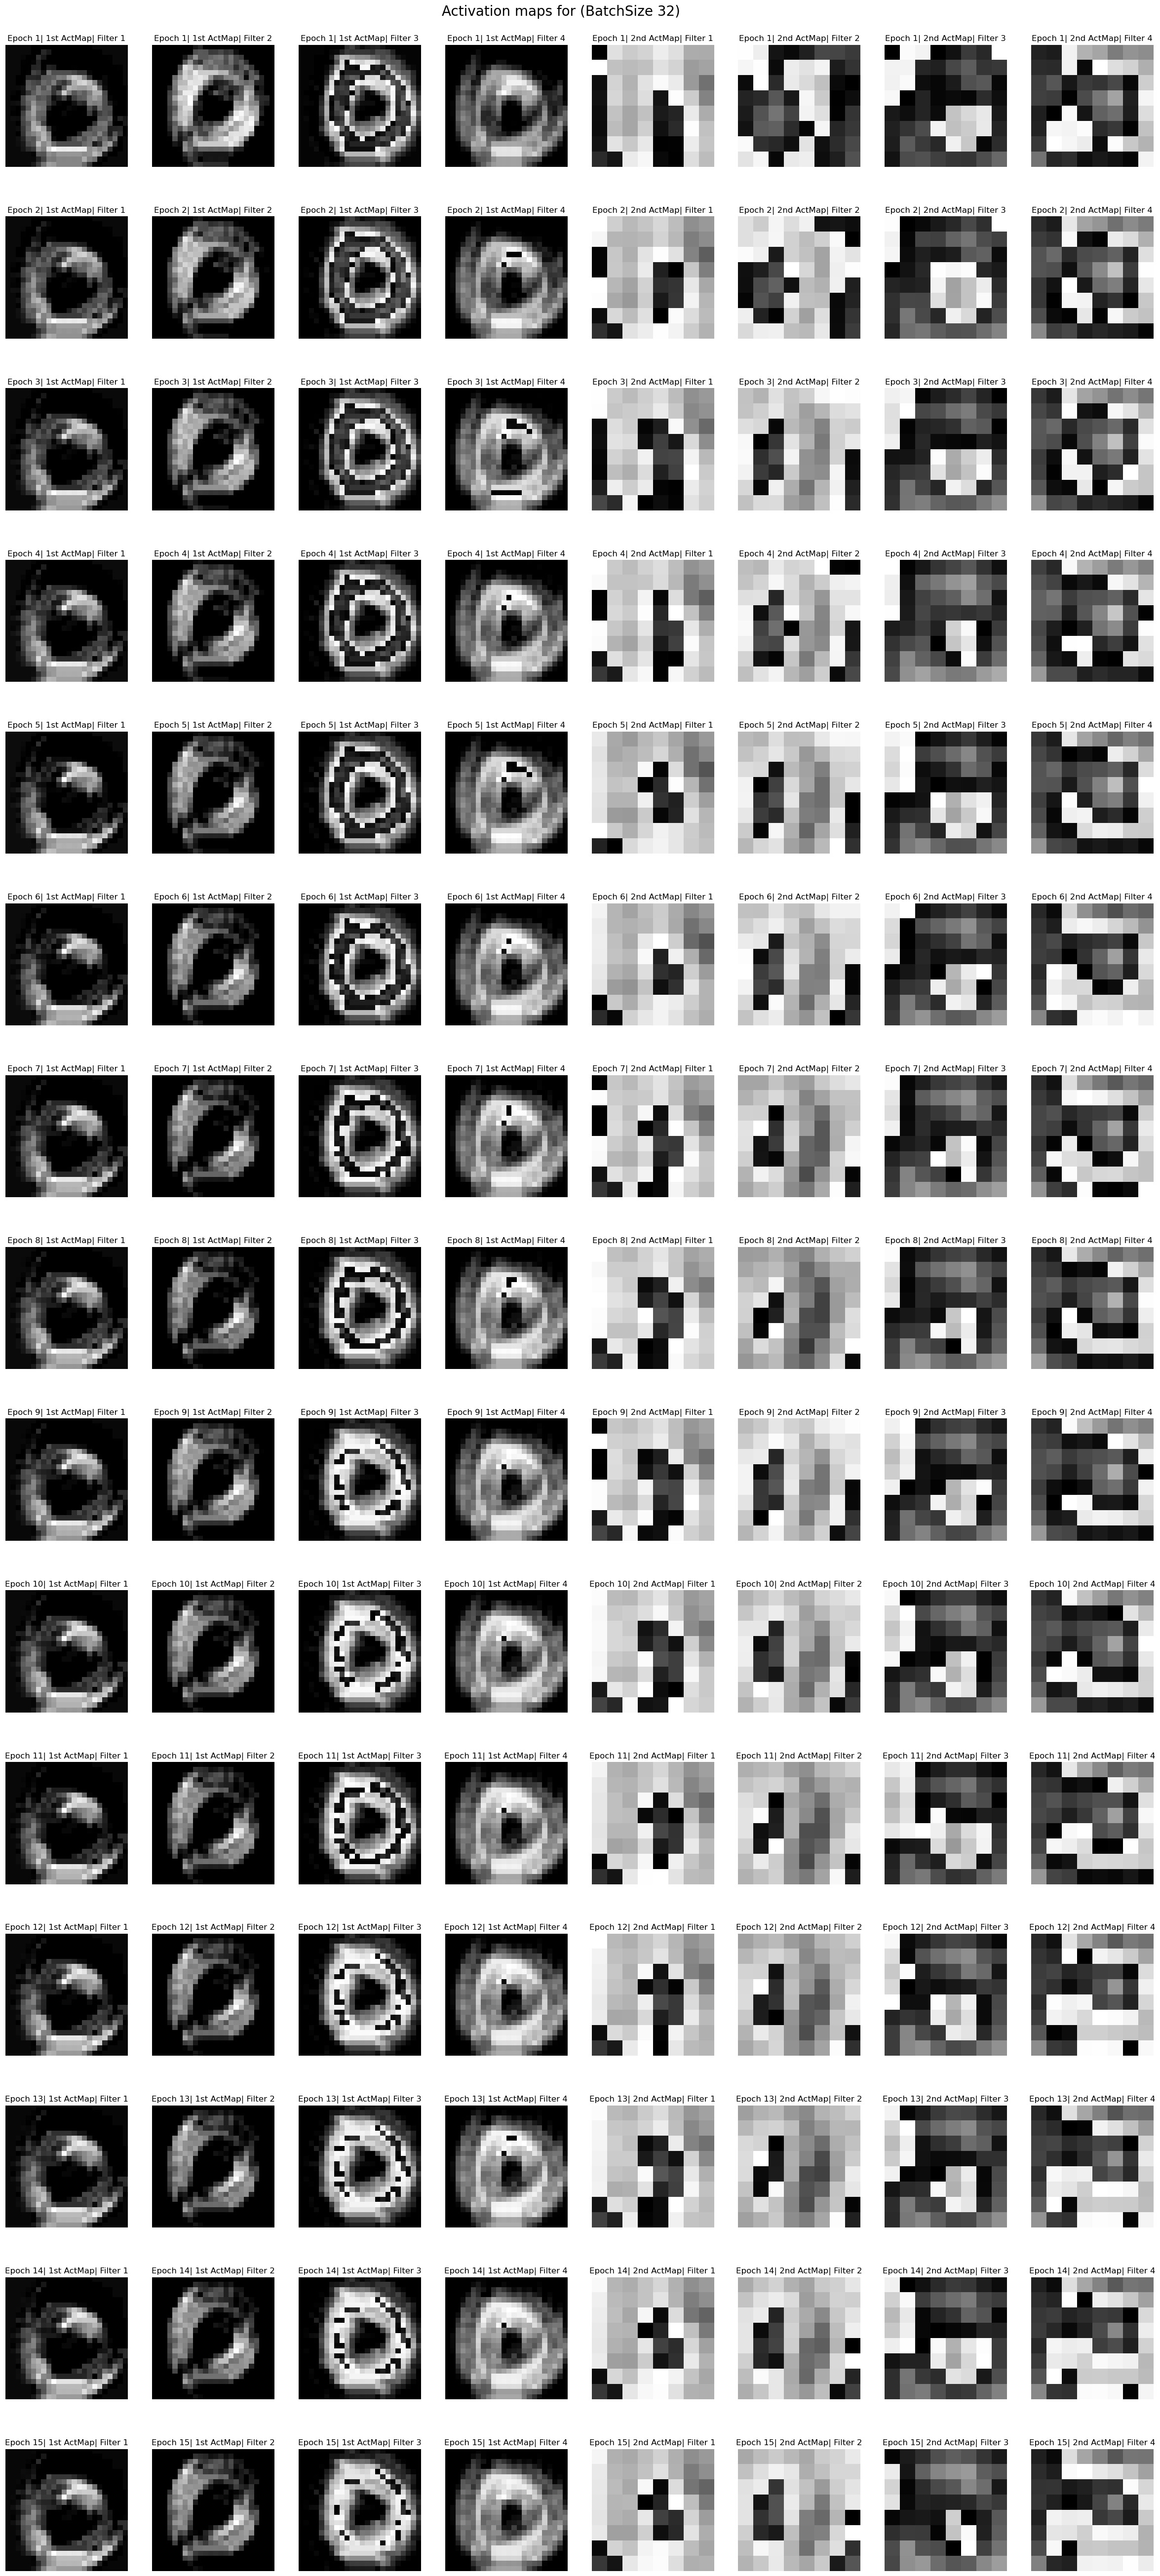

In [30]:
# Plotting the activation maps for BatchSize_32
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_32"]["activation_map1"]
activation_map2 = cache["BatchSize_32"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 32)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

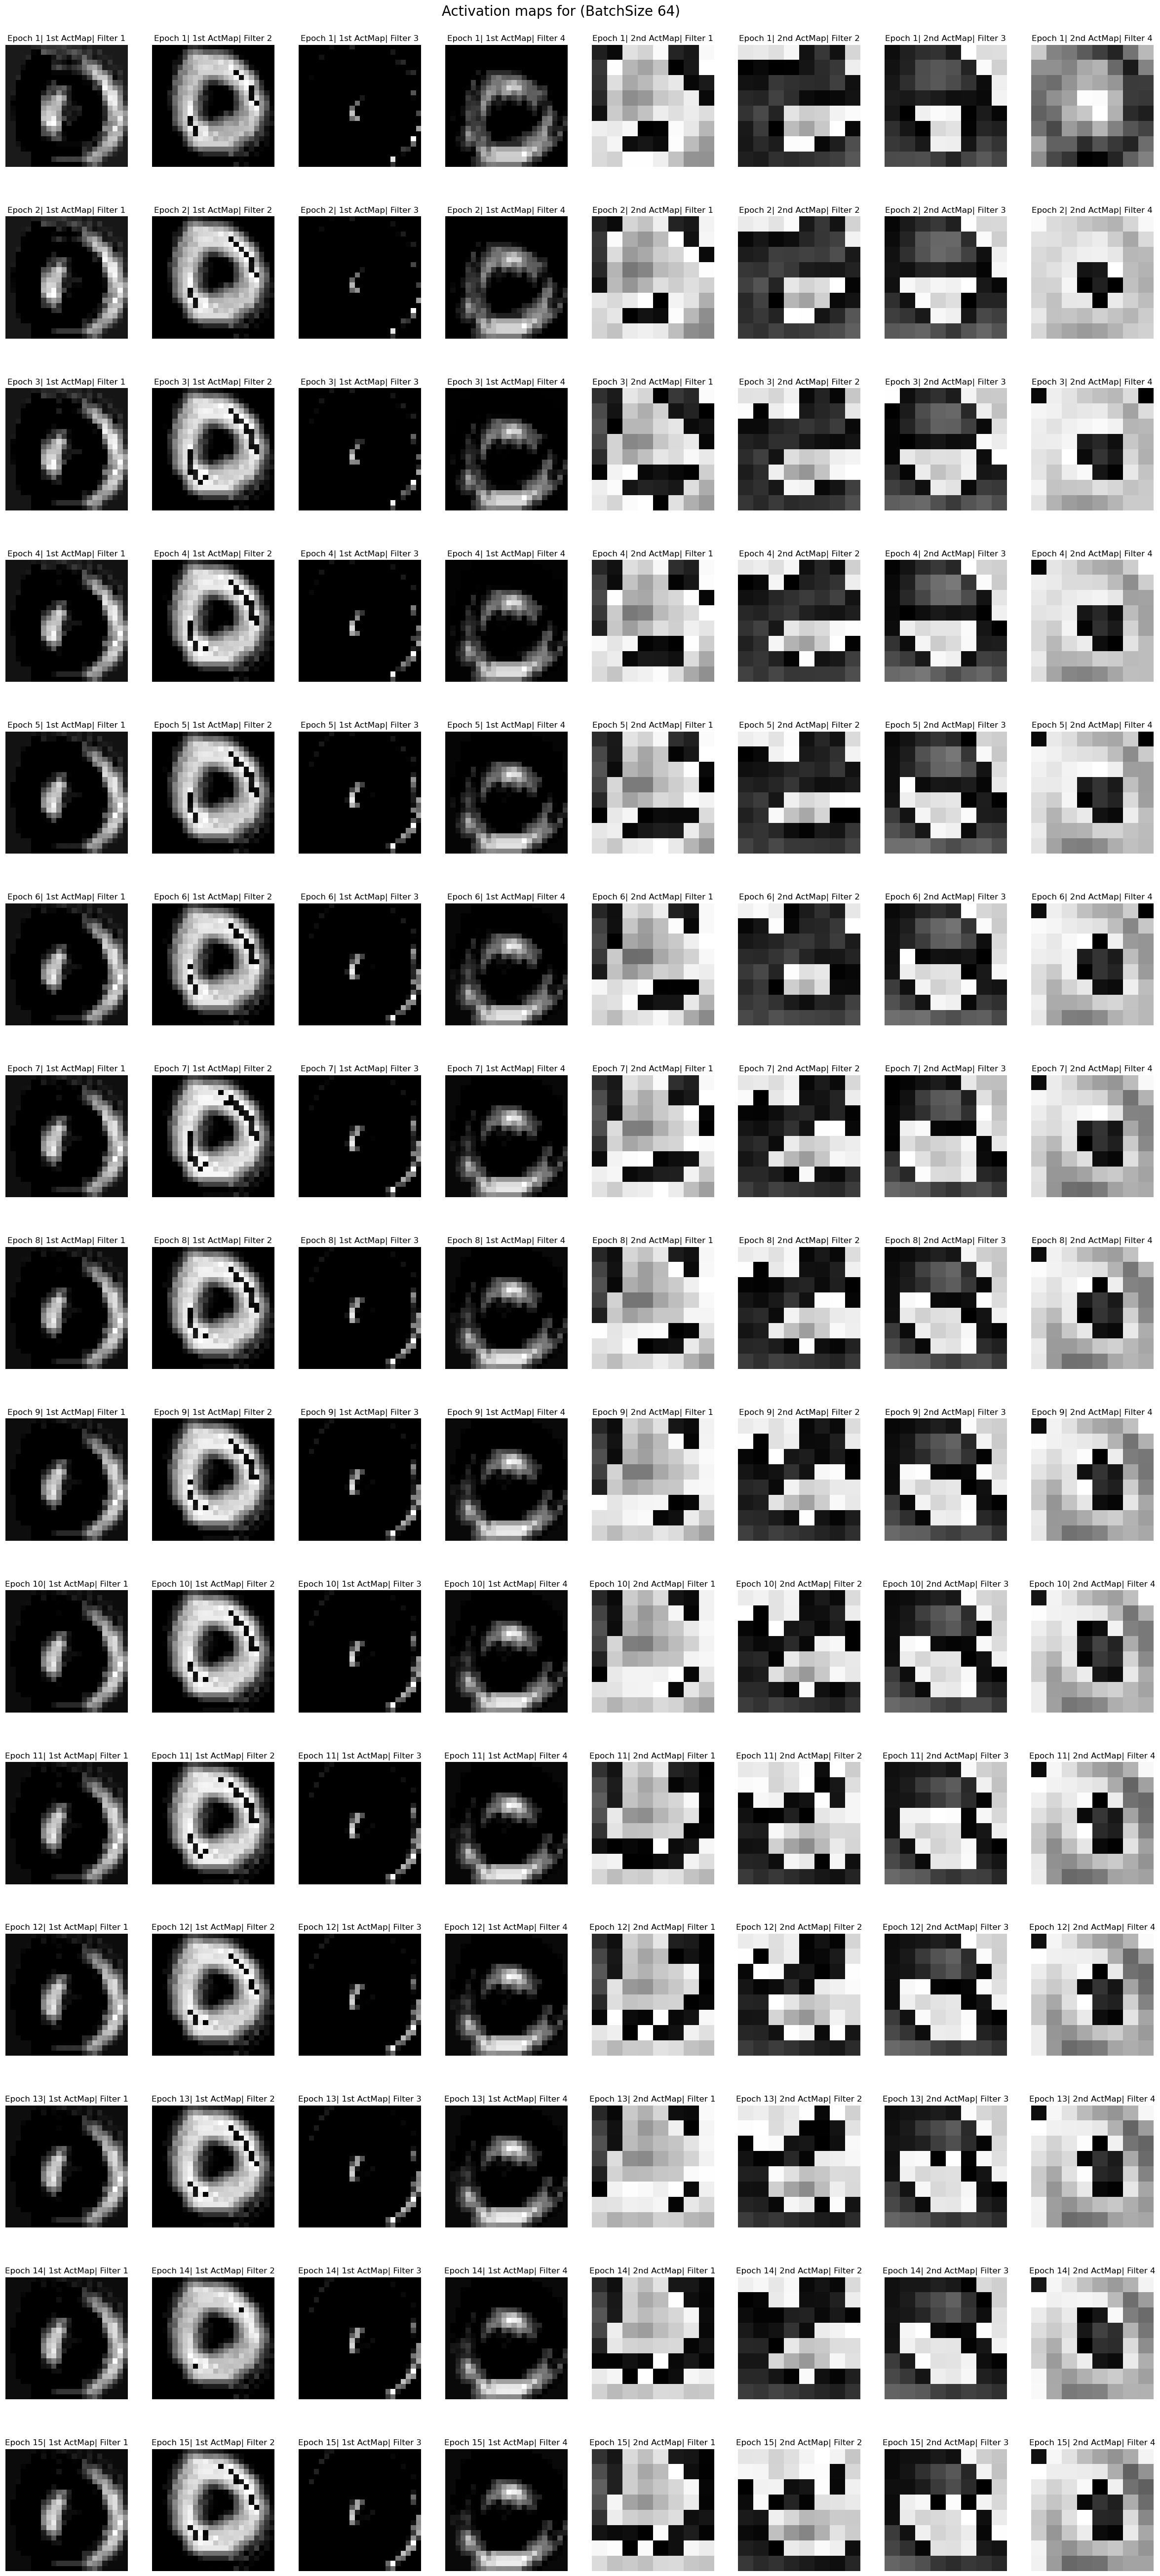

In [31]:
# Plotting the activation maps for BatchSize_64
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_64"]["activation_map1"]
activation_map2 = cache["BatchSize_64"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 64)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

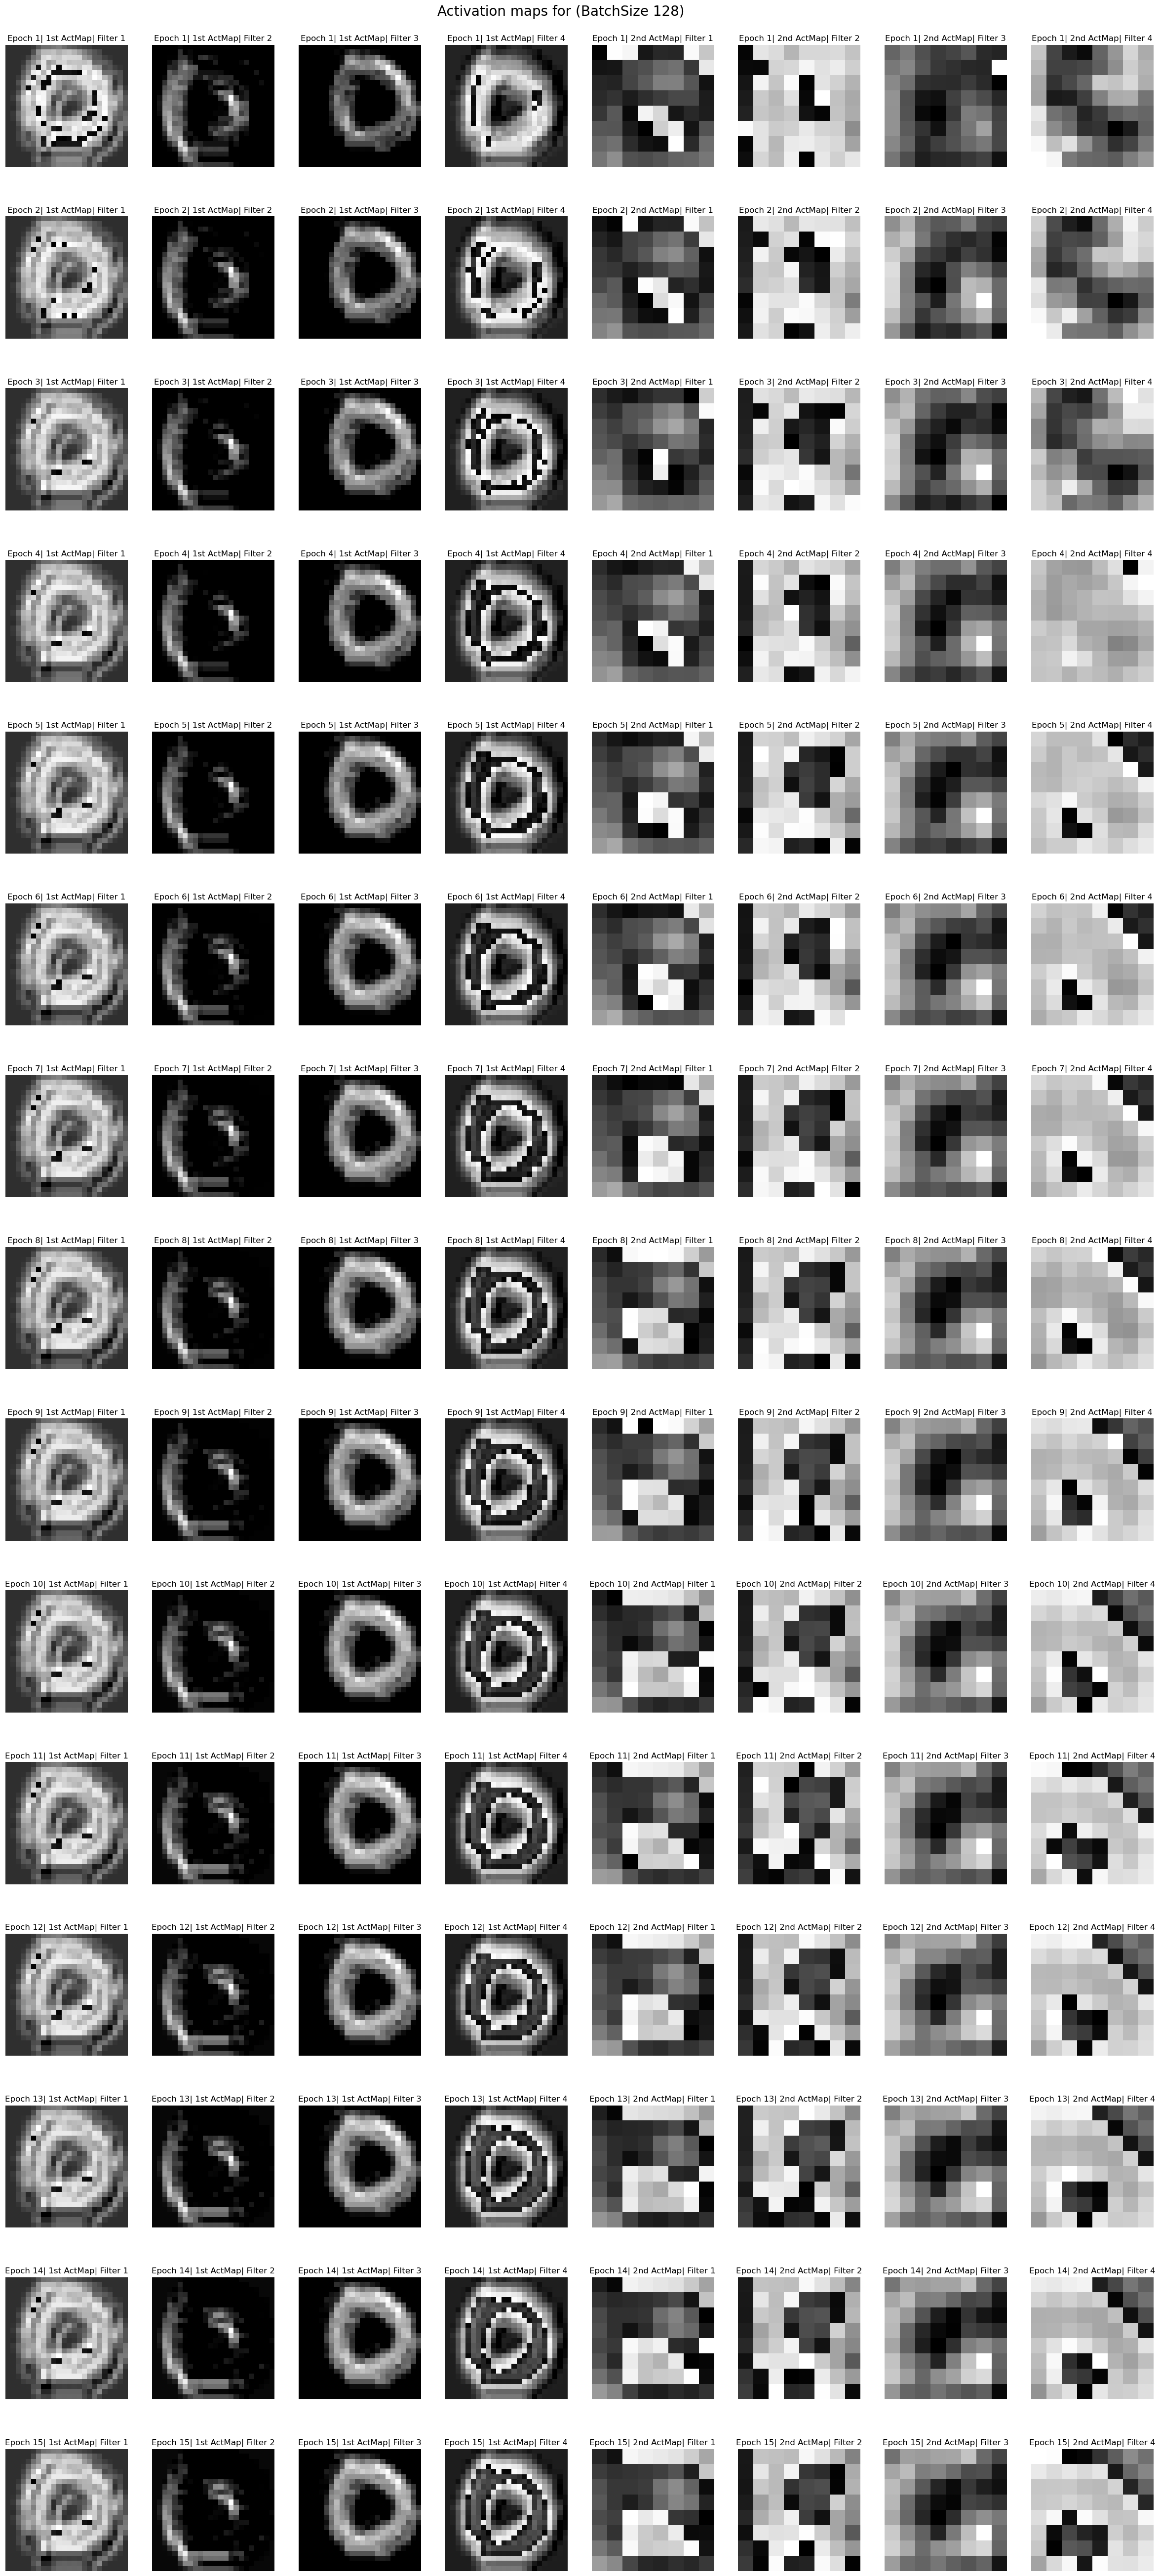

In [32]:
# Plotting the activation maps for BatchSize_128
plt.figure(figsize=(30, 60))
activation_map1 = cache["BatchSize_128"]["activation_map1"]
activation_map2 = cache["BatchSize_128"]["activation_map2"]

for idx, (image1, image2) in enumerate(zip(activation_map1, activation_map2)):
    for i in range(4):
        plt.subplot(15, 8, 8 * idx + i + 1)
        plt.imshow(image1[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 1st ActMap| Filter {i + 1}")

        plt.subplot(15, 8, 8 * idx + i + 5)
        plt.imshow(image2[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Epoch {idx + 1}| 2nd ActMap| Filter {i + 1}")

plt.suptitle("Activation maps for (BatchSize 128)", fontsize=20)
plt.subplots_adjust(top=0.97)
plt.show()

### TSNE

In [33]:
def getBottleneckFeatures(model, testloader):
    """
    Returns the bottleneck features of the model.

    Parameters
    ----------
    model : nn.Module
        The model to use.
    testloader : torch.utils.data.DataLoader
        The test data.
    
    Returns
    -------
    bottleneck_features : np.ndarray
        The bottleneck features of the model.
    labels : np.ndarray
        The labels of the test data.
    """

    model.eval()
    bottleneck_features = []
    labels = []

    with torch.no_grad():
        for data, target in testloader:
            output = model.convolution_layer1(data)
            output = model.maxpool1(output)
            output = model.convolution_layer2(output)
            output = model.maxpool2(output)
            output = output.view(-1, model.flatten_dim)
            bottleneck_features.append(output.detach().numpy())
            labels.append(target.detach().numpy())

    bottleneck_features = np.concatenate(bottleneck_features, axis=0)
    labels = np.concatenate(labels, axis=0)    

    return bottleneck_features, labels

In [34]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

### TSNE for Vanilla SGD

In [35]:
model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Getting the bottleneck features for all the images in the test set
before_training = getBottleneckFeatures(model, testloader)

# Training a model for 15 epochs using RMSprop
for epoch in range(epochs):
    model.train()
    model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)

# Getting the bottleneck features for all the images in the test set
after_training = getBottleneckFeatures(model, testloader)

In [36]:
before_training_features, before_training_labels = before_training
after_training_features, after_training_labels = after_training

before_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(before_training_features) 
after_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(after_training_features)

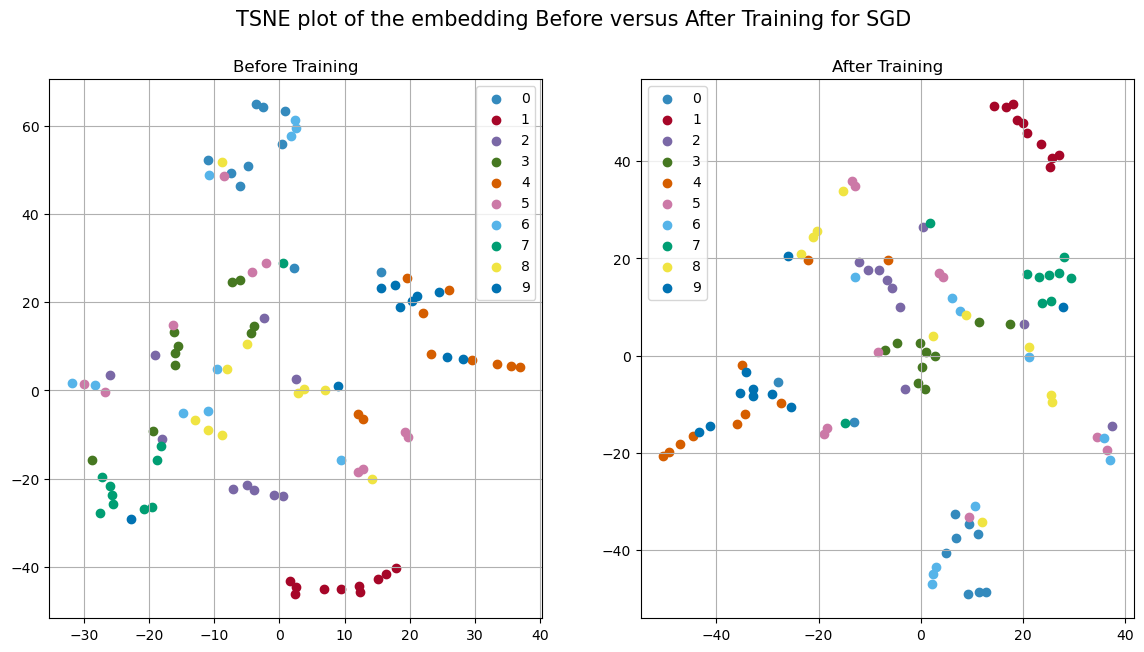

In [37]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(10):
    index = np.where(before_training_labels == i)[0]
    plt.scatter(before_training_features[index, 0], before_training_features[index, 1], label=str(i))
plt.title("Before Training")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(10):
    index = np.where(after_training_labels == i)[0]
    plt.scatter(after_training_features[index, 0], after_training_features[index, 1], label=str(i))
plt.legend()
plt.grid(True)
plt.title("After Training")
plt.suptitle("TSNE plot of the embedding Before versus After Training for SGD", fontsize=15)
plt.show()

### TSNE for SGD with Momentum

In [38]:
model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Getting the bottleneck features for all the images in the test set
before_training = getBottleneckFeatures(model, testloader)

# Training a model for 15 epochs using RMSprop
for epoch in range(epochs):
    model.train()
    model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)

# Getting the bottleneck features for all the images in the test set
after_training = getBottleneckFeatures(model, testloader)

In [39]:
before_training_features, before_training_labels = before_training
after_training_features, after_training_labels = after_training

before_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(before_training_features) 
after_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(after_training_features)

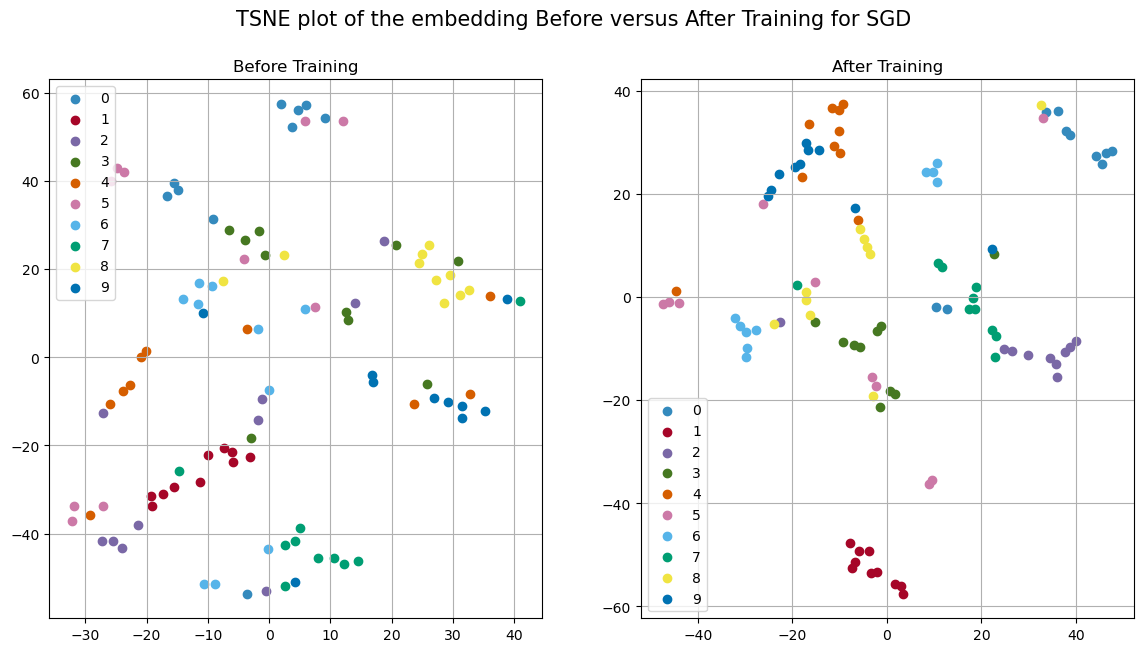

In [40]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(10):
    index = np.where(before_training_labels == i)[0]
    plt.scatter(before_training_features[index, 0], before_training_features[index, 1], label=str(i))
plt.title("Before Training")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(10):
    index = np.where(after_training_labels == i)[0]
    plt.scatter(after_training_features[index, 0], after_training_features[index, 1], label=str(i))
plt.legend()
plt.grid(True)
plt.title("After Training")
plt.suptitle("TSNE plot of the embedding Before versus After Training for SGD", fontsize=15)
plt.show()

### TSNE for RMSProp

In [41]:
model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Getting the bottleneck features for all the images in the test set
before_training = getBottleneckFeatures(model, testloader)

# Training a model for 15 epochs using RMSprop
for epoch in range(epochs):
    model.train()
    model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)

# Getting the bottleneck features for all the images in the test set
after_training = getBottleneckFeatures(model, testloader)

In [42]:
before_training_features, before_training_labels = before_training
after_training_features, after_training_labels = after_training

before_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(before_training_features) 
after_training_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(after_training_features)

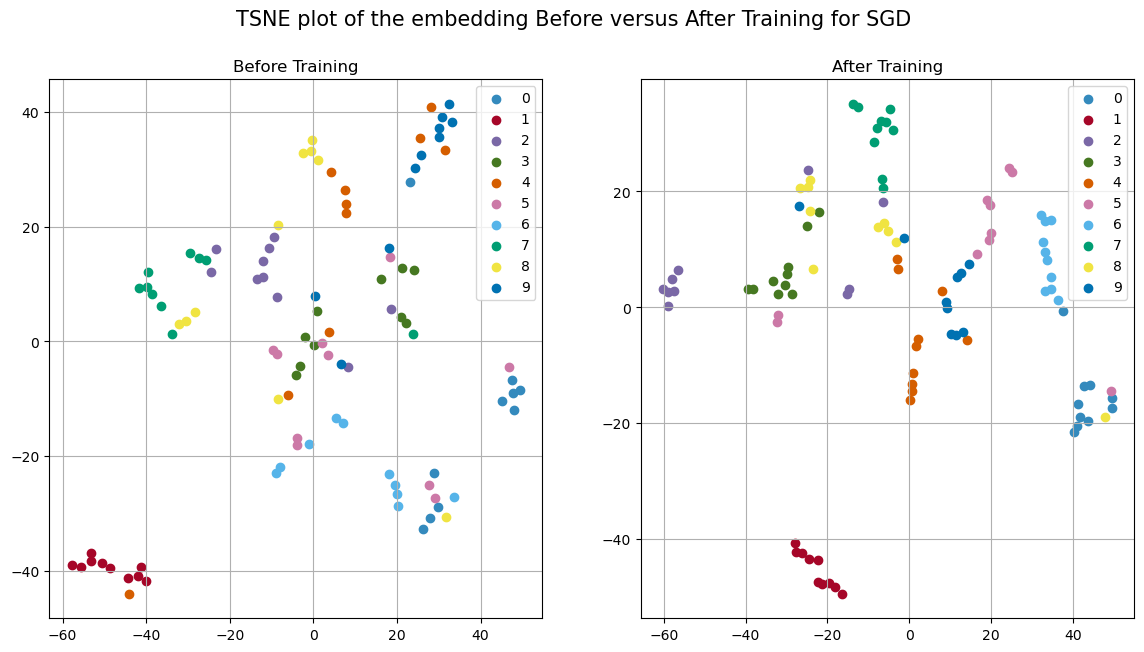

In [43]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(10):
    index = np.where(before_training_labels == i)[0]
    plt.scatter(before_training_features[index, 0], before_training_features[index, 1], label=str(i))
plt.title("Before Training")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(10):
    index = np.where(after_training_labels == i)[0]
    plt.scatter(after_training_features[index, 0], after_training_features[index, 1], label=str(i))
plt.legend()
plt.grid(True)
plt.title("After Training")
plt.suptitle("TSNE plot of the embedding Before versus After Training for SGD", fontsize=15)
plt.show()

### Dropout Layer

In [44]:
dropout_probs = [0.2, 0.5, 0.8]

In [45]:
cache = {}
for idx, dropout in enumerate(dropout_probs):
    model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10, dropout=dropout)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        model, _, train_accuracy = trainLoop(model, trainloader, optimizer)
        _, val_accuracy = valLoop(model, testloader)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    cache_per_batch["train_accuracies"] = train_accuracies
    cache_per_batch["val_accuracies"] = val_accuracies
    cache[f"Dropout_{dropout}"] = cache_per_batch.copy()

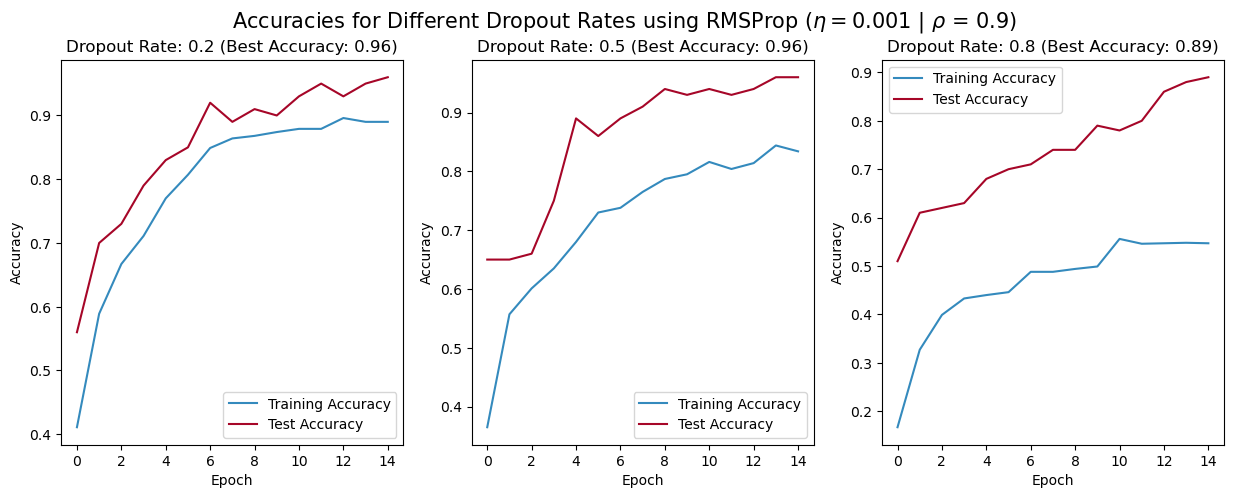

In [46]:
# Plotting the training and validation accuracy
plt.figure(figsize=(5 * len(cache), 5))

for idx, key in enumerate(cache.keys()):
    train_accuracies = cache[key]["train_accuracies"]
    val_accuracies = cache[key]["val_accuracies"]

    plt.subplot(1, len(cache), idx + 1)
    plt.plot(train_accuracies, label=f"Training Accuracy")
    plt.plot(val_accuracies, label=f"Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Dropout Rate: {key.split('_')[1]} (Best Accuracy: {max(val_accuracies):.2f})")
    plt.legend()
plt.suptitle(r"Accuracies for Different Dropout Rates using RMSProp ($\eta = 0.001$ | $\rho$ = 0.9)", fontsize=15)
plt.show()

From the above plot, we infer that the train accuracy is low when we use dropout because some of the neurons are randomly dropped. But, when we are testing the dropout layer is not being used and hence the accuracy is high. When comparing to the model without dropout, the model with dropout has a lower train accuracy but a higher test accuracy. This is because the model without dropout is overfitting the training data and hence the test accuracy is low.

Moreover, in most of the cases, the model with dropout has a higher test accuracy than the model without dropout. This is because the model with dropout is more robust and hence generalizes better.

### BatchNormalisation

In [47]:
model = ImageClassifier(image_shape=(28, 28, 1), num_classes=10, dropout=0.2, batch_norm=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    model, _, train_accuracy = trainLoop(model, trainloader, optimizer)
    _, val_accuracy = valLoop(model, testloader)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

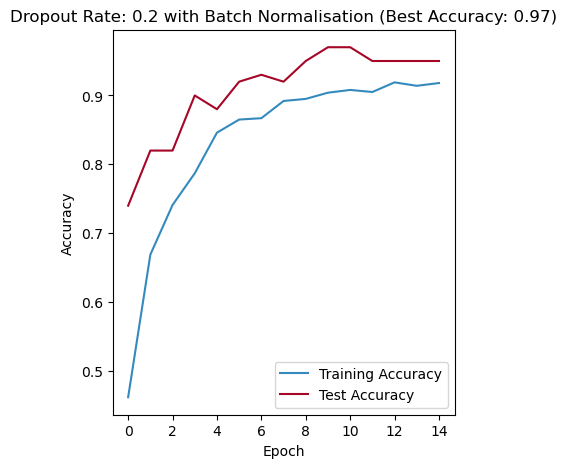

In [48]:
# Plotting the training and validation accuracy
plt.figure(figsize=(5 * len(cache), 5))

plt.subplot(1, len(cache), idx + 1)
plt.plot(train_accuracies, label=f"Training Accuracy")
plt.plot(val_accuracies, label=f"Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Dropout Rate: 0.2 with Batch Normalisation (Best Accuracy: {max(val_accuracies):.2f})")
plt.legend()
plt.show()

From the above plot, we infer that it still follows the case that train accuracy is lesser than the test accuracy because of the dropout layer. But, the train accuracy is higher than the model with dropout. This is because the batch normalization layer normalizes the input to the next layer and scales it according to the weights and biases. This helps in faster convergence and hence the train accuracy is higher.